# Problem Description


You are presented with a dataset `train_data.csv` that contains the daily sales for
more than 1000 stores of a chain.

In addition, we provide the dataset `store.csv` that
contains details for each store.

Your task is to build a model that predicts the daily sales for the test data set.

Please provide:
- Programming code, preferrably python for the soluton (and if not obvious --
instructions how to run it)
- Your reasoning about the problem and the solution you provided (data
analysis, feature selection, model approach, ...)
- Your predictions in the form of a CSV file

For the first two parts you can pick your own format; it can be code + separate
document, commented code, Jupyter notebook, etc.

## Data description 
### train.csv and test.csv
- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (prediction target)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions,
are closed on state holidays. Note that all schools are closed on public holidays
and weekends.
    -  a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public
schools

### store.csv
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince [Month/Year] - gives the approximate year and month of
the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - is a continuing and consecutive promotion for some stores: 0 = store is
not participating, 1 = store is participating
- Promo2Since [Year/Week] - describes the year and calendar week when the store
started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming
the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each
round starts in February, May, August, November of any given year for that store

# Imports and constants

In [46]:
import warnings
warnings.filterwarnings('ignore')
# Data manipulation + EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling.visualisation.plot import timeseries_heatmap
from statsmodels.tsa.seasonal import seasonal_decompose 
# Modeling
from etna.datasets.tsdataset import TSDataset
from etna.transforms import FilterFeaturesTransform
from etna.transforms import MeanTransform  # math
from etna.transforms import DateFlagsTransform  # datetime
from etna.transforms import LagTransform  # lags
from etna.transforms.encoders.categorical import LabelEncoderTransform
from etna.transforms.missing_values.imputation import TimeSeriesImputerTransform
from etna.metrics import SMAPE, R2, RMSE
from etna.models import LinearPerSegmentModel, CatBoostPerSegmentModel, CatBoostModelMultiSegment
from etna.pipeline import Pipeline
# Metrics
# from sklearn.metrics import r2_score
# TS plotting
from etna.analysis import cross_corr_plot, sample_acf_plot

from etna.analysis.outliers import get_anomalies_median, get_anomalies_density
from etna.analysis import plot_anomalies


# Part 0. Raw data loading + basic preprocessing

In [188]:
# Train
train_df = pd.read_csv("./data/train.csv", parse_dates=['Date'])
# Data fix #1 in col StateHoliday we have different (str and int) types of `0` --> cast all to str
train_df.StateHoliday = train_df.StateHoliday.apply(str) 
display(train_df.sample(3))
# Test
test_df = pd.read_csv("./data/test.csv", parse_dates=['Date'])
# Data fix #2 in test sample we have NaN Open col for Store == 662.
# after stats checking on train via train_df[train_df.Store == 622].groupby("DayOfWeek").Open.value_counts()
# Let's mark all missed records with DayOfWeek != 7 as Open = 1
open_to_fill_1_index = test_df[(test_df.Open.isna()) & (test_df.DayOfWeek != 7)].index
open_to_fill_0_index = test_df[(test_df.Open.isna()) & (test_df.DayOfWeek == 7)].index 
for _ind in open_to_fill_1_index:
    test_df.at[_ind, 'Open'] = 1.0
for _ind in open_to_fill_0_index:
    test_df.at[_ind, 'Open'] = 0.0
test_df.Open = test_df.Open.astype(int)
test_df.StateHoliday = test_df.StateHoliday.apply(str) 
display(test_df.sample(3))

pd.DataFrame([train_df.Date.describe(), test_df.Date.describe()], index=['train', 'test'])


Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
900448    314          1 2013-04-15   4078        504     1      0   
923254    820          2 2013-03-26  11420        988     1      1   
698502    183          7 2013-10-13      0          0     0      0   

       StateHoliday  SchoolHoliday  
900448            0              0  
923254            0              1  
698502            0              0

Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  \
38276  38277    793          2 2015-08-04     1      1            0   
34141  34142    983          7 2015-08-09     0      0            0   
8158    8159    586          2 2015-09-08     1      0            0   

       SchoolHoliday  
38276              1  
34141              0  
8158               0

count  unique        top  freq      first       last
train  1017209     942 2015-07-31  1115 2013-01-01 2015-07-31
test     41088      48 2015-09-17   856 2015-08-01 2015-09-17

We have only 48 days in our test data - so I'd transform this into business formulation - we should be able to predict for a given store daily sales amount for the next 48 days.

This clearly guides us on how validation sample size. Gladly, we have pretty large history in train 942 days (through with NaN gaps) - so we can design a Cross-Validation through time there.

In [33]:
store_df = pd.read_csv("./data/store.csv")
display(store_df.StoreType.value_counts())
display(store_df.Assortment.value_counts())
# TODO add StoreType, Assortment and CompetitionDistance as exo variables
joined_train_df = train_df.merge(store_df, on='Store')
display(joined_train_df.sample(3))
joined_test_df = test_df.merge(store_df, on='Store')
display(joined_test_df.sample(3))

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

a    593
c    513
b      9
Name: Assortment, dtype: int64

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
201557    223          3 2014-08-20   7523        769     1      1   
641633    705          3 2015-02-04   9291       1045     1      1   
871785    957          1 2014-09-29  11887       1198     1      1   

       StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
201557            0              1         d          c               2920.0   
641633            0              0         a          a               4140.0   
871785            0              0         d          c               1420.0   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
201557                       10.0                    1995.0       1   
641633                        9.0                    2012.0       1   
871785                       11.0                    2012.0       0   

        Promo2SinceWeek  Promo2SinceYear    PromoInterval  
201557             27.0           2011.0  Jan,Apr,Jul,Oct  
641633             18.0           2011.0  Feb,May,Aug,Nov  
871785              NaN              NaN              NaN

Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  \
19175  20088    520          2 2015-08-25     1      0            0   
9318    5331    252          5 2015-09-11     1      0            0   
25666  29639    693          5 2015-08-14     1      0            0   

       SchoolHoliday StoreType Assortment  CompetitionDistance  \
19175              1         a          c               6900.0   
9318               0         d          c              22330.0   
25666              1         d          a                450.0   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
19175                        NaN                       NaN       1   
9318                         NaN                       NaN       1   
25666                        NaN                       NaN       1   

       Promo2SinceWeek  Promo2SinceYear     PromoInterval  
19175             40.0           2012.0  Mar,Jun,Sept,Dec  
9318               5.0           2010.0   Feb,May,Aug,Nov  
25666             40.0           2011.0   Jan,Apr,Jul,Oct

# Part 1. Initial EDA 

In [30]:
both_stats_df = joined_train_df.groupby(['Assortment', 'StoreType'])[["Sales", "Customers", "Promo2", "Open"]].describe().T.apply(lambda x: round(x, 2))
print('Assortment X StoreType stats pivot')
display(both_stats_df)


Assortment X StoreType stats pivot


Assortment               a                                        b  \
StoreType                a         b         c          d         b   
Sales     count  346389.00   6594.00  70878.00  113584.00   8294.00   
          mean     5398.86  10821.62   5647.17    5317.89   8553.93   
          std      3722.91   5864.05   3483.83    3258.39   3882.42   
          min         0.00      0.00      0.00       0.00      0.00   
          25%      3301.00   6804.50   3915.00    3709.00   5523.00   
          50%      5312.00   9389.00   5841.00    5507.00   8026.50   
          75%      7426.00  13814.75   7797.75    7330.00  11233.25   
          max     38025.00  38722.00  28242.00   33071.00  22137.00   
Customers count  346389.00   6594.00  70878.00  113584.00   8294.00   
          mean      627.00   1754.34    693.91     482.74   2046.36   
          std       434.20    960.25    423.29     285.78    867.68   
          min         0.00      0.00      0.00       0.00      0.00   
          25%       390.00   1027.00    487.00     360.00   1370.00   
          50%       619.00   1574.00    724.00     507.00   1879.50   
          75%       858.00   2318.00    961.00     653.00   2661.75   
          max      7388.00   5494.00   2976.00    2239.00   4645.00   
Promo2    count  346389.00   6594.00  70878.00  113584.00   8294.00   
          mean        0.47      0.14      0.50       0.59      0.43   
          std         0.50      0.35      0.50       0.49      0.50   
          min         0.00      0.00      0.00       0.00      0.00   
          25%         0.00      0.00      0.00       0.00      0.00   
          50%         0.00      0.00      0.00       1.00      0.00   
          75%         1.00      0.00      1.00       1.00      1.00   
          max         1.00      1.00      1.00       1.00      1.00   
Open      count  346389.00   6594.00  70878.00  113584.00   8294.00   
          mean        0.83      0.97      0.83       0.83      0.99   
          std         0.38      0.17      0.38       0.38      0.10   
          min         0.00      0.00      0.00       0.00      0.00   
          25%         1.00      1.00      1.00       1.00      1.00   
          50%         1.00      1.00      1.00       1.00      1.00   
          75%         1.00      1.00      1.00       1.00      1.00   
          max         1.00      1.00      1.00       1.00      1.00   

Assortment               c                                 
StoreType                a         b         c          d  
Sales     count  205238.00    942.00  65962.00  199328.00  
          mean     6310.87  17969.56   5805.78    5826.41  
          std      4280.12   2931.93   3959.79    3577.07  
          min         0.00   8498.00      0.00       0.00  
          25%      3974.00  16078.50   3657.00    4181.00  
          50%      6176.00  18029.50   5688.00    6008.00  
          75%      8561.00  19867.75   7914.00    7890.00  
          max     41551.00  28680.00  31448.00   38037.00  
Customers count  205238.00    942.00  65962.00  199328.00  
          mean      713.11   3105.05    651.08     512.09  
          std       503.14    330.30    437.46     295.43  
          min         0.00   1663.00      0.00       0.00  
          25%       461.00   2914.25    432.00     387.00  
          50%       692.00   3127.00    639.00     544.00  
          75%       943.00   3314.75    871.00     696.00  
          max      4911.00   4099.00   3096.00    2153.00  
Promo2    count  205238.00    942.00  65962.00  199328.00  
          mean        0.46      0.00      0.50       0.56  
          std         0.50      0.00      0.50       0.50  
          min         0.00      0.00      0.00       0.00  
          25%         0.00      0.00      0.00       0.00  
          50%         0.00      0.00      1.00       1.00  
          75%         1.00      0.00      1.00       1.00  
          max         1.00      0.00      1.00       1.00  
Open      count  205238.0

We can note that Stores of `StoreType` == `b` opened almost always by looking at Open col mean stats >=0.97, 
I will assume that other `Storetype` tend to be closed on Weekends

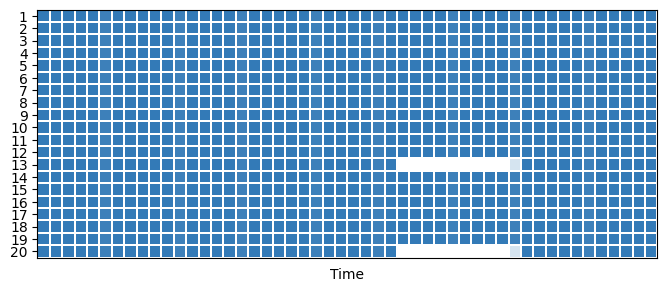

In [7]:
#Let's have a look what data distribution for each store we have in history (train)
timeseries_heatmap(dataframe=joined_train_df, entity_column='Store', sortby='Date', 
    max_entities=20, figsize=(8, 15), selected_entities=None)
pass

As we can see, there are significant gaps in history for some Stores. Later we will work on it.

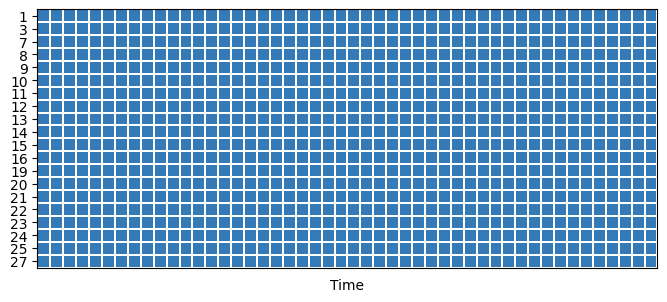

In [9]:
timeseries_heatmap(dataframe=test_df, entity_column='Store', sortby='Date', 
    max_entities=20, figsize=(8, 15), selected_entities=None)
pass

We also can note that test data contains just a fraction of shops from train, let's doublecheck that

In [11]:
print("Number of stores in train excluded from test:", len(set(train_df.Store.unique()) - set(test_df.Store.unique())))
print("Unknown stores in test:", len(set(test_df.Store.unique()) - set(train_df.Store.unique())))


Number of stores in train excluded from test: 259
Unknown stores in test: 0


Gladly, there are no unknown stores in our test

In [15]:
def plot_stats_for_single_store(df, store_id, decomposition_col="Sales", violin_target_cols=["Sales", "Customers"], violin_hue_cols=["Promo", "SchoolHoliday", "StateHoliday"]):
    """
        Method for pre-setuped EDA plots. Types of plots included:
        - Seasonal decomposition plots for target_col on weekly, wonthly and yearly period
        - Paired (on categorical feature) violin plots for target_col grouped by DayOfWeek vs hue column
    """
    def pair_violin_plot(_df, x, y_list, hue, split):
        axs = plt.figure(constrained_layout=True, figsize=(12,5)).subplots(1, 2, sharex=False, sharey=False)
        for i, _ax in enumerate(axs):
            sns.violinplot(data=_df, x=x, y=y_list[i], hue=hue, ax=_ax, cut=0, split=split)
        plt.show()

    def plot_seasonal_decompose(df, col, period, title):
        result = seasonal_decompose(df.set_index('Date')[col], model='additive', extrapolate_trend='freq', period=period)
        fg = result.plot(weights=True)
        fg.set_constrained_layout(True)
        fg.autofmt_xdate(rotation=45)
        fg.set_size_inches(16, 8)
        fg.suptitle(title)
        plt.show()
    store_df = df[df.Store == store_id]
    # store_df = store_df[store_df.Sales != 0]
    # store_df.Sales = store_df.Sales.apply(np.log)
    store_df.set_index("Date")[['Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday']].plot(subplots=True, figsize=(12,9))
    plt.show()
    # pair_violin_plot(store_df, x="DayOfWeek", y_list=["Sales", "Customers", 'avg_bill'], hue="Open", split=)
    for hue in violin_hue_cols:
        pair_violin_plot(store_df, x="DayOfWeek", y_list=violin_target_cols, hue=hue, split=False)
    for period in [7, 30, 365]:
        plot_seasonal_decompose(store_df, decomposition_col, period=period, title=f"{period} days decomposition")
    

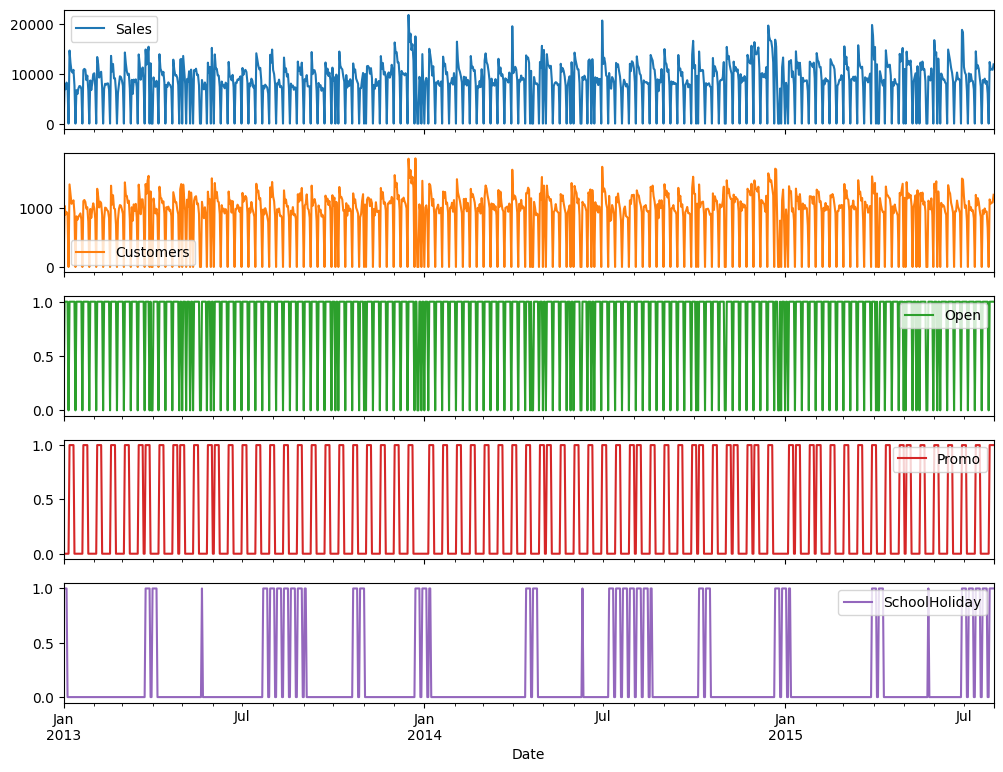

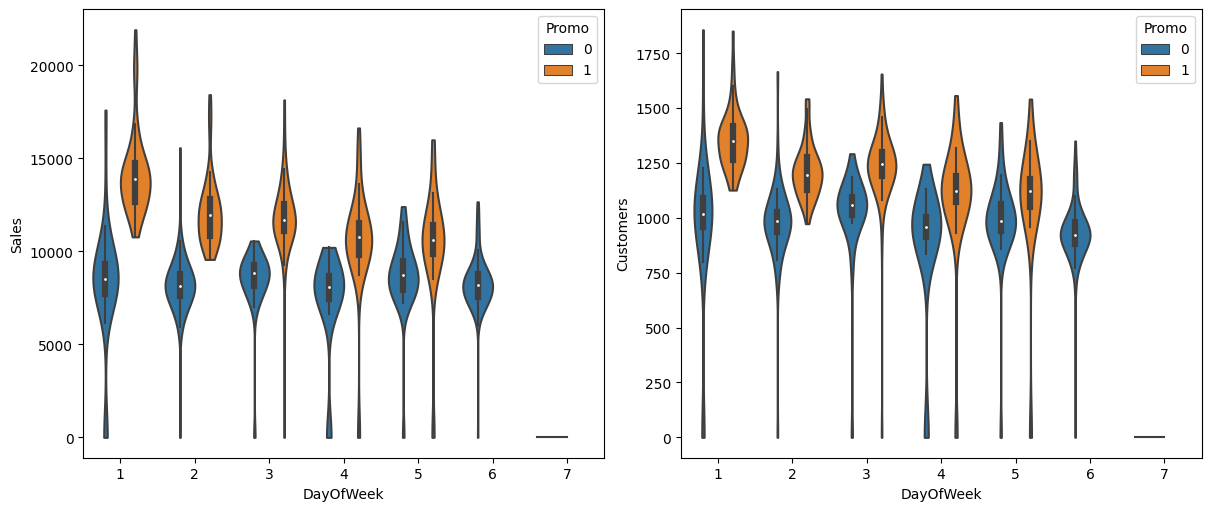

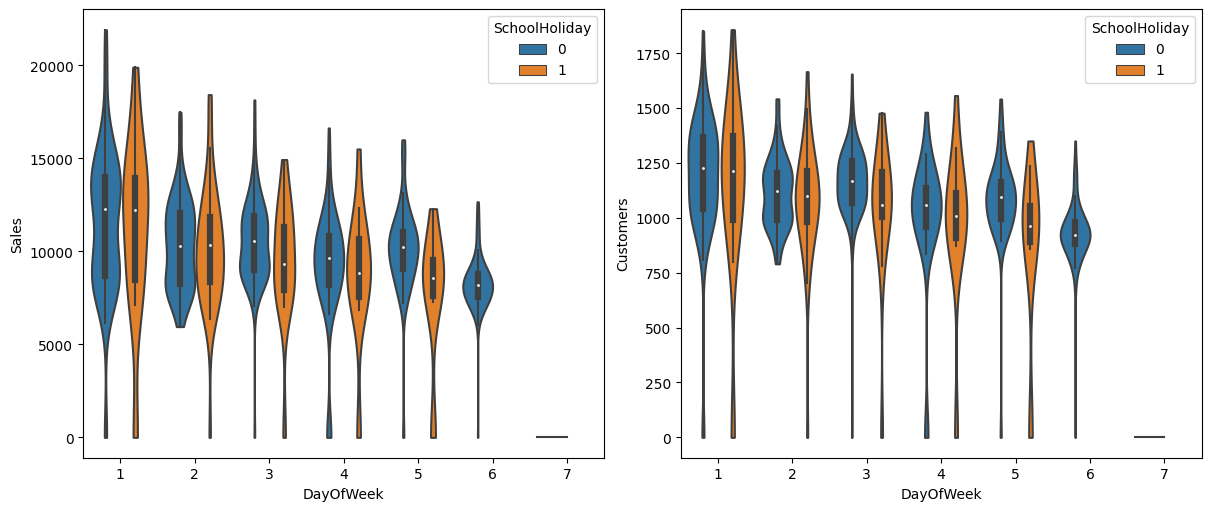

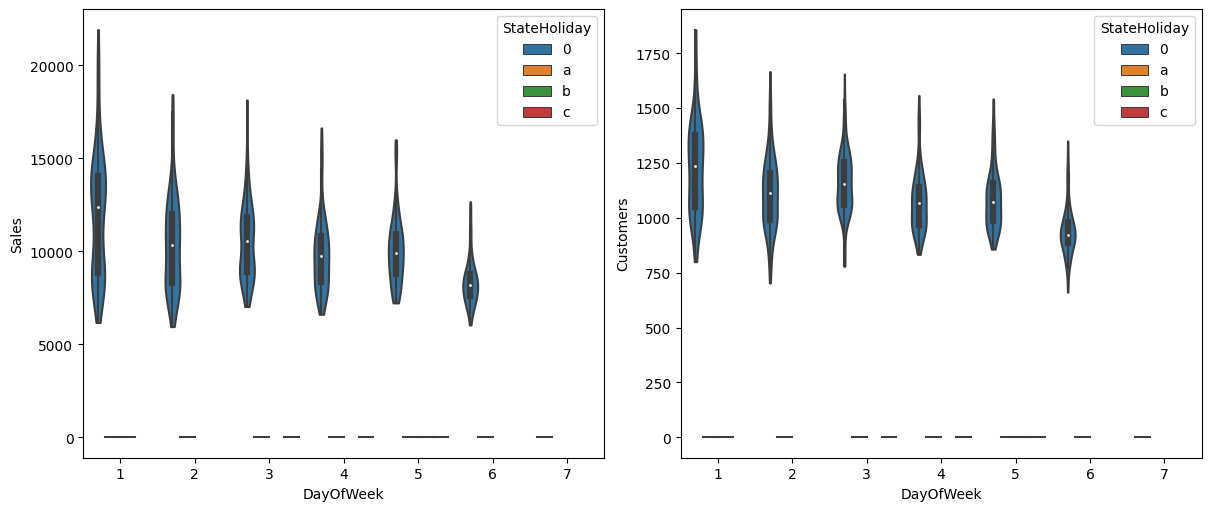

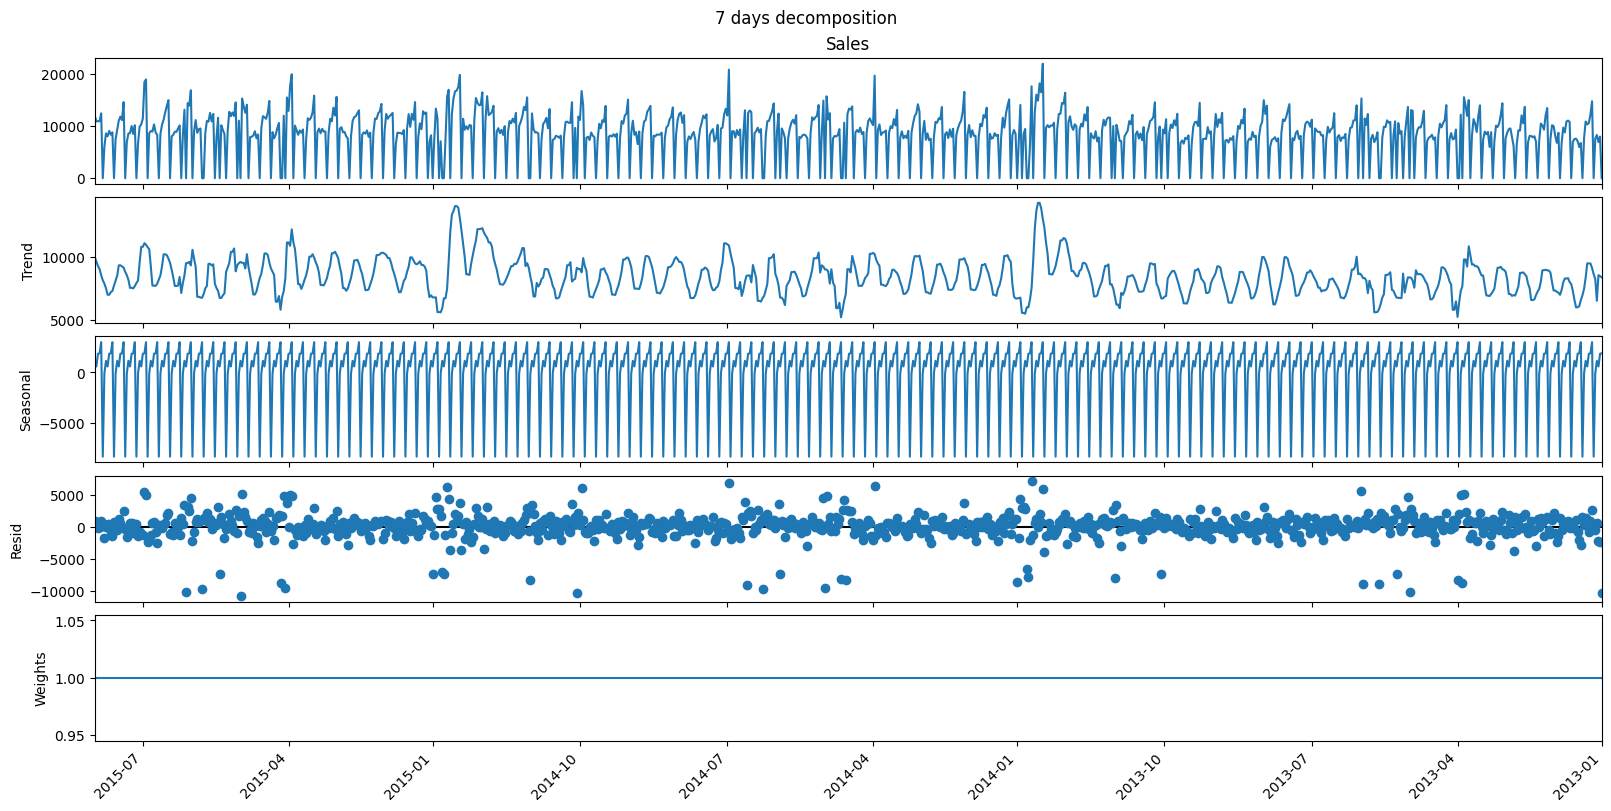

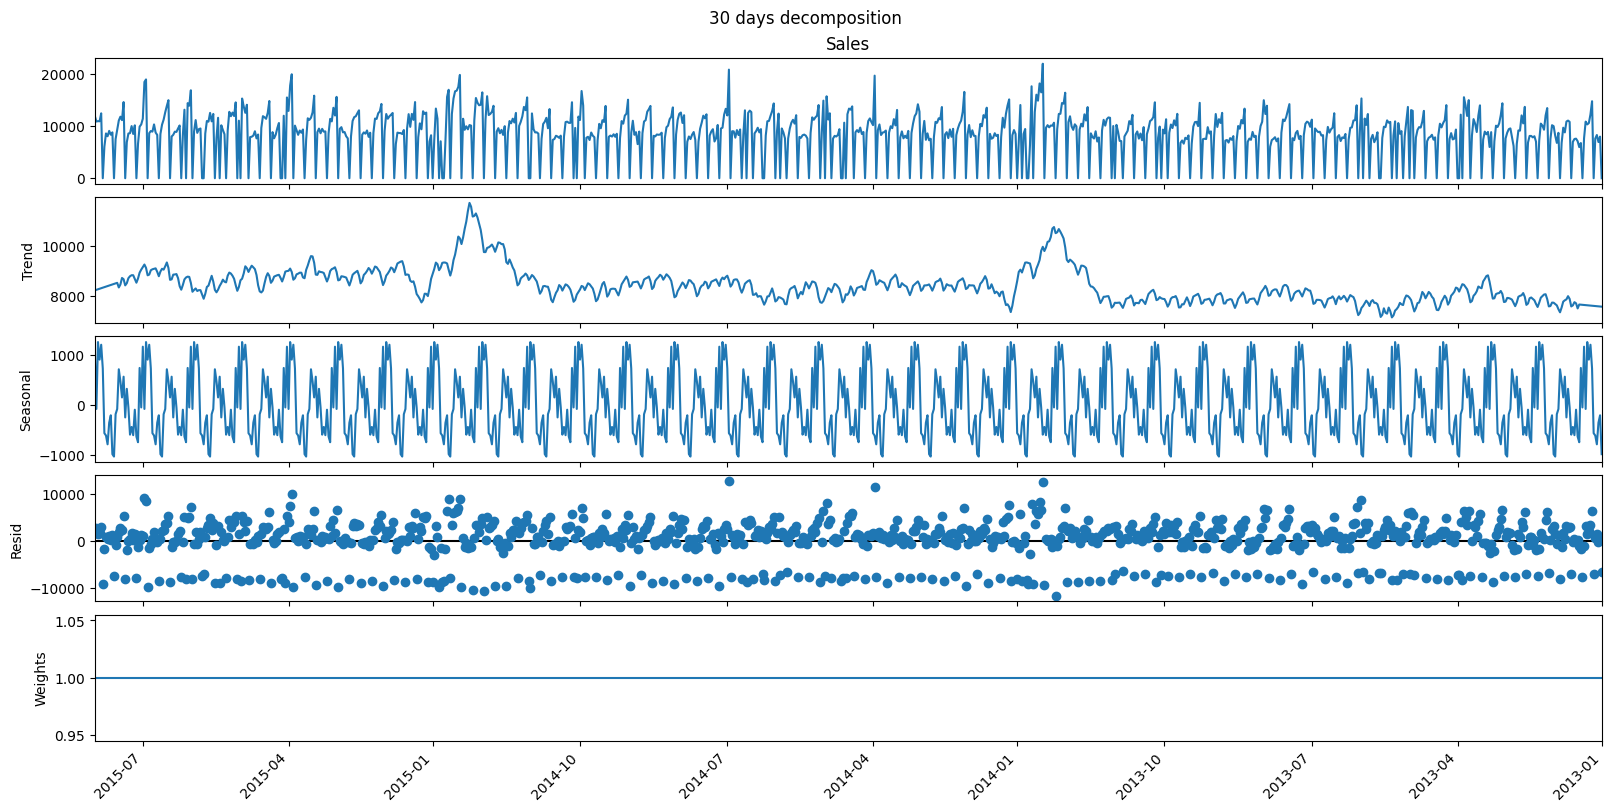

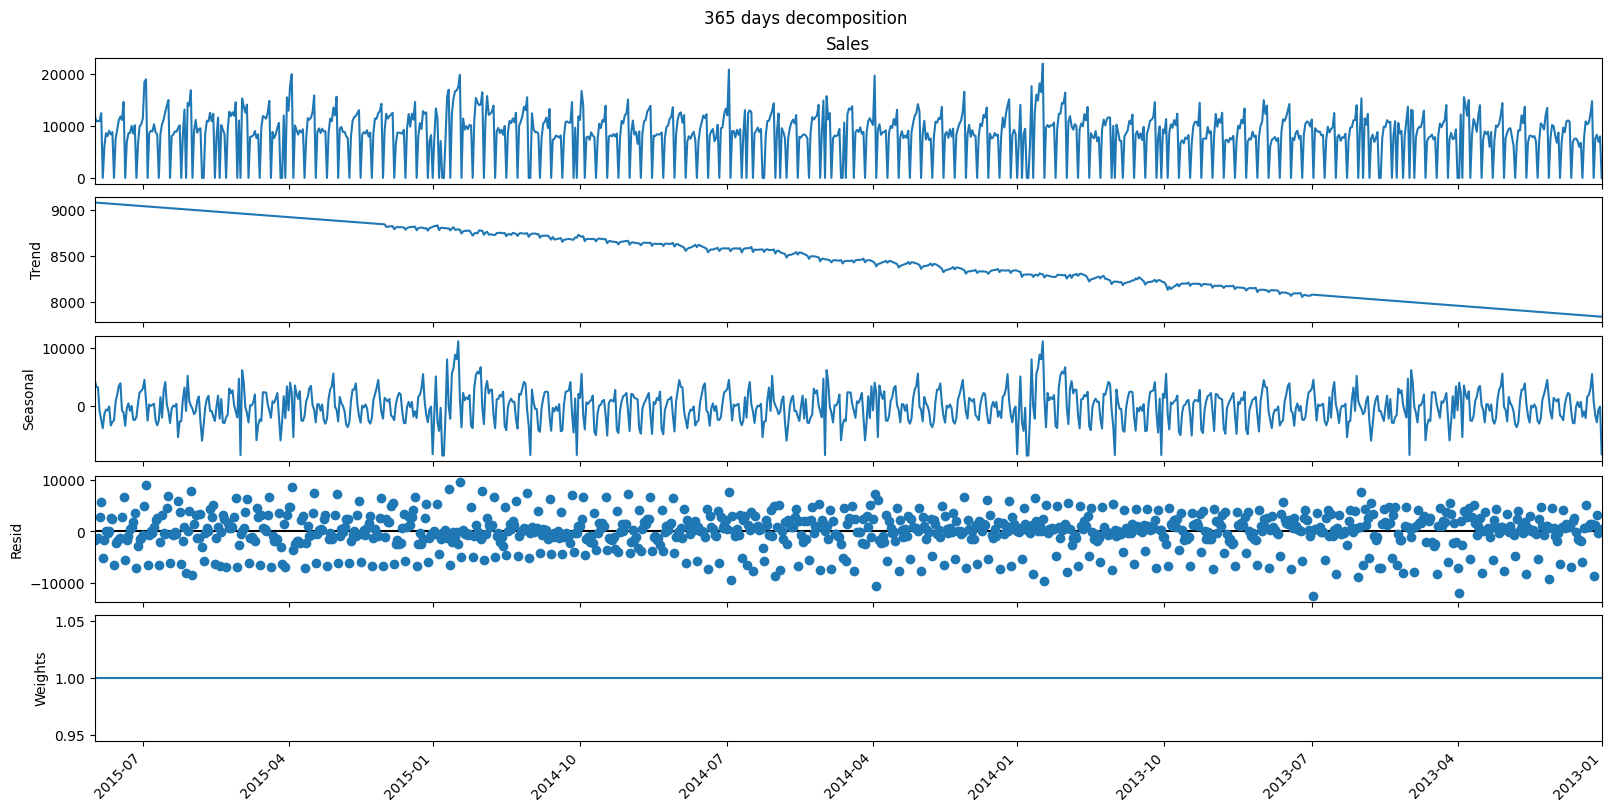

In [16]:
plot_stats_for_single_store(train_df, store_id=42)

In [17]:
# plot_stats_for_single_store(train_df, store_id=13)

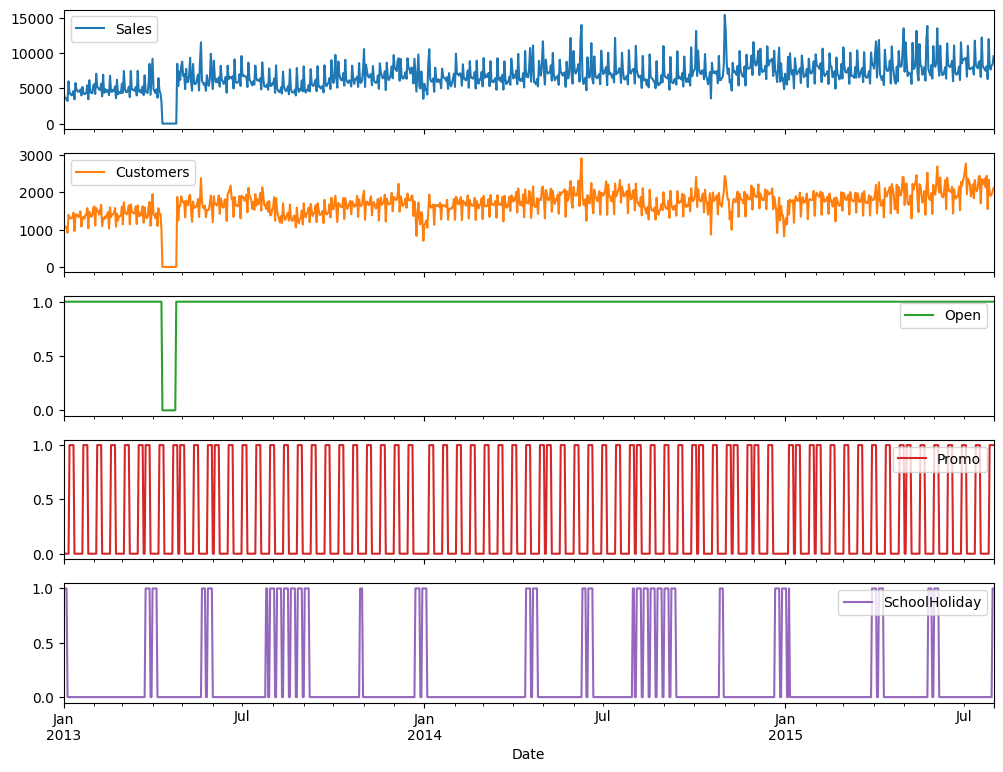

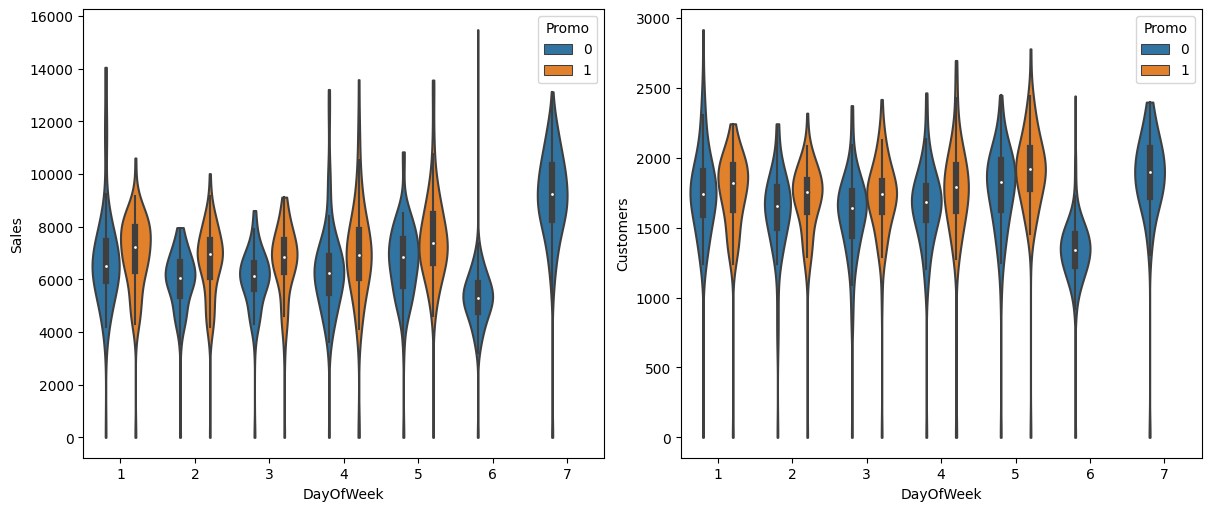

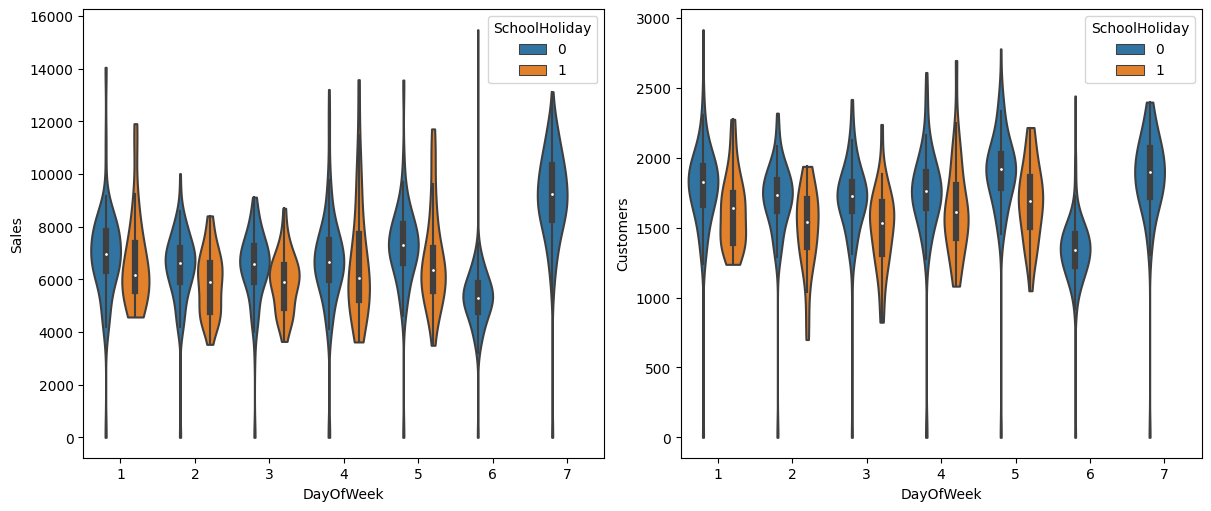

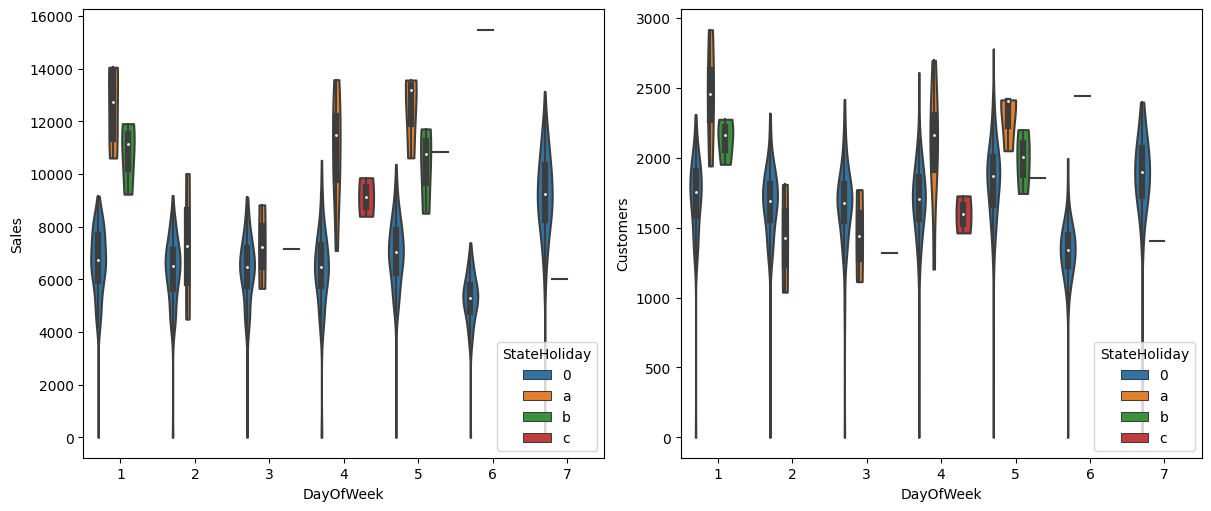

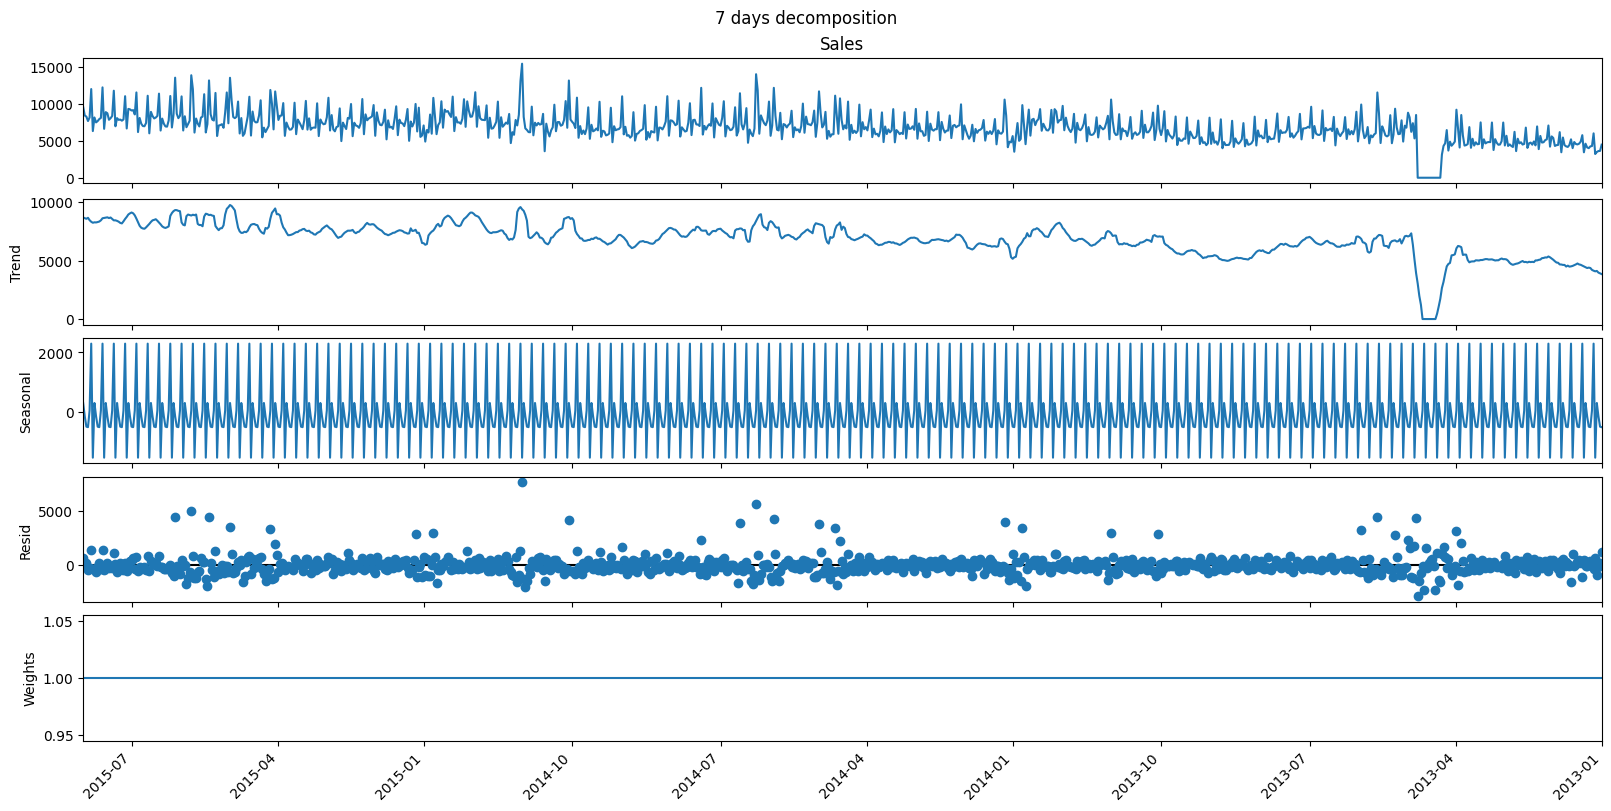

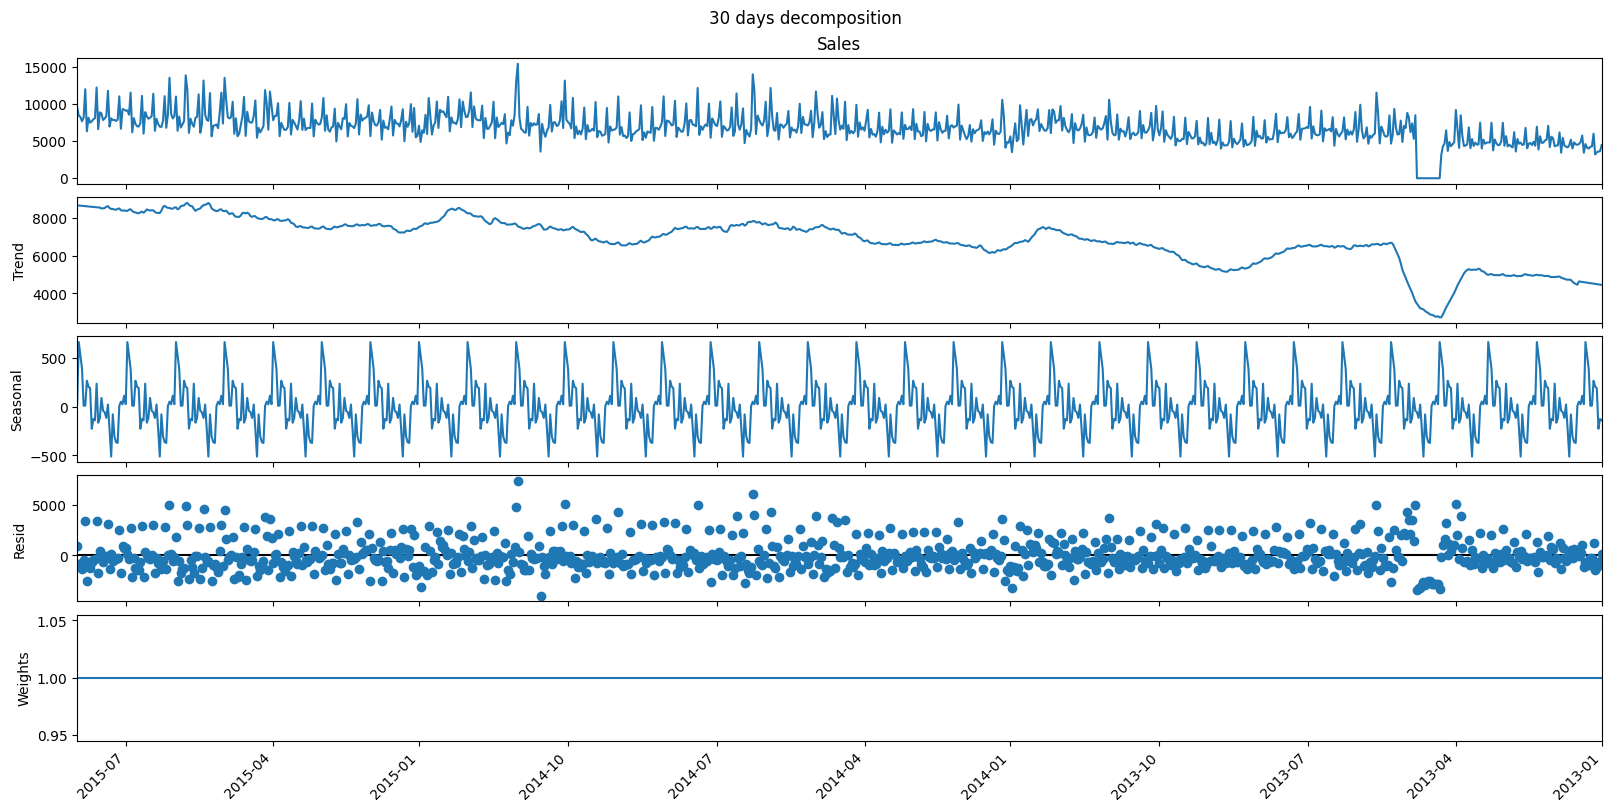

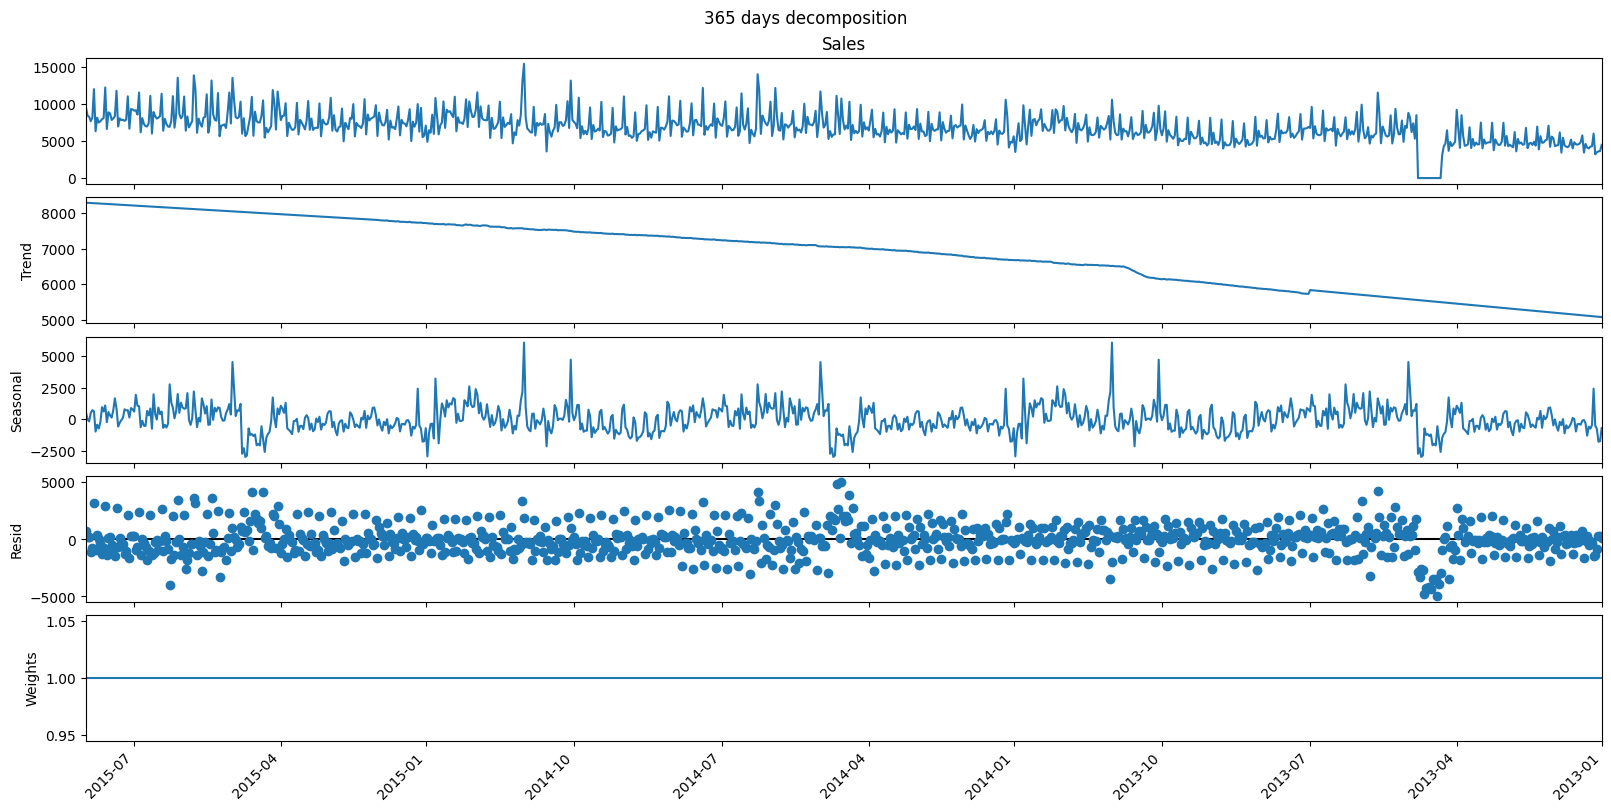

In [19]:
plot_stats_for_single_store(train_df, store_id=948)

We can highlight the following:
- We are working with different work schedule Stores
- Sales dynamic has clear Weekly and Monthly seasonality
- Sales dynamic has Yearly linear trend

# Part 2. Let's do more processing + baseline model:
 - We will do simple postprocessing step for cases when `Store` is closed - we expect here 0 `Sales`.
 - We will re-label records with (train_df.`Open` == 1) & (train_df.`Sales` == 0) as `Open`=1 because from my perspective they seem like an data error. 
   - It should be validated with data\business owner, but for now let's assume that as is.
 - We will apply np.log1p function to `Sales`, because of it's non-negative distribution - we want to transform it to become distributed ~ normal. It's a known best practice for `Sales` prediction.
 - We will work with github.com/tinkoff-ai/etna library for abovementioned preprocessing.
 - In etna all the processing happens inside `TSDataset` abstraction. 
 - To convert `Pandas` into `TSDataset` we need to:
    - Rename `Store` as `segment`. It indicates different time series within dataset.
    - Rename `Date` as `timestamp`.
    - Rename `Sales` as `target`
    - Map `Promo`, `StateHoliday`, and `SchoolHoliday` as regressors. These are exogenous factors that are known for us in future (test).

In [48]:
# Creating etna TSDataset
HORIZON = 48
NUM_DAYS_TRAIN = 200

def prepare_df(df, test_df):
    exog_col_list = ["timestamp", "segment", "Open", "Promo", "StateHoliday", "SchoolHoliday", "StoreType", "Assortment"]
    exog_categorical_cols = ["Promo", "StateHoliday", "SchoolHoliday", "StoreType", "Assortment"]
    # re-label Open
    open_store_without_purchase_index = df[(df.Open == 1) & (df.Sales == 0)].index
    for _index in open_store_without_purchase_index:
        df.at[_index, "Open"] = 0
    ml_train_df = df.copy()
    ml_train_df.Sales = ml_train_df.Sales.apply(np.log1p)
    ml_train_df.rename(columns={"Date": "timestamp", "Sales": "target", "Store": "segment"}, inplace=True)
    # TODO try to filter out 0 Sales
    # IMPORTANT - we use test here only to collect exogeneous data for properly setup train dataset and be ready to forecast for the test.
    test_exog_df = (test_df
        .rename(columns={"Date": "timestamp","Store": "segment"})[exog_col_list]
        .copy())
    # Model breaks if there no future exog vals in test - workaround filtering
    ml_train_df = ml_train_df[ml_train_df.segment.isin(test_exog_df.segment.unique())]

    ml_exog_df = ml_train_df[exog_col_list]
    ml_exog_df = ml_exog_df.append(test_exog_df, ignore_index=True)

    for col in exog_categorical_cols:
        ml_exog_df[col] = ml_exog_df[col].astype("category")

    ml_train_df = ml_train_df[["timestamp", "segment", "target"]]
    # here we filter out our first day since a lot of stores hasn't had data for it
    ml_train_df = ml_train_df[ml_train_df.timestamp >= "2013-01-02"]
    ml_exog_df = ml_exog_df[ml_exog_df.timestamp >= "2013-01-02"]
    return ml_train_df, ml_exog_df
etna_train_df, etna_exog_df = prepare_df(joined_train_df, joined_test_df)

In [40]:
pd.DataFrame([etna_exog_df.timestamp.describe(), etna_train_df.timestamp.describe()], index=['Exog', 'Endog'])

count  unique        top  freq      first       last
Exog   813464     989 2015-07-31   856 2013-01-02 2015-09-17
Endog  772376     941 2015-07-31   856 2013-01-02 2015-07-31

In [41]:
ts_df = TSDataset(df=TSDataset.to_dataset(etna_train_df), df_exog=TSDataset.to_dataset(etna_exog_df), freq="D", known_future="all",)

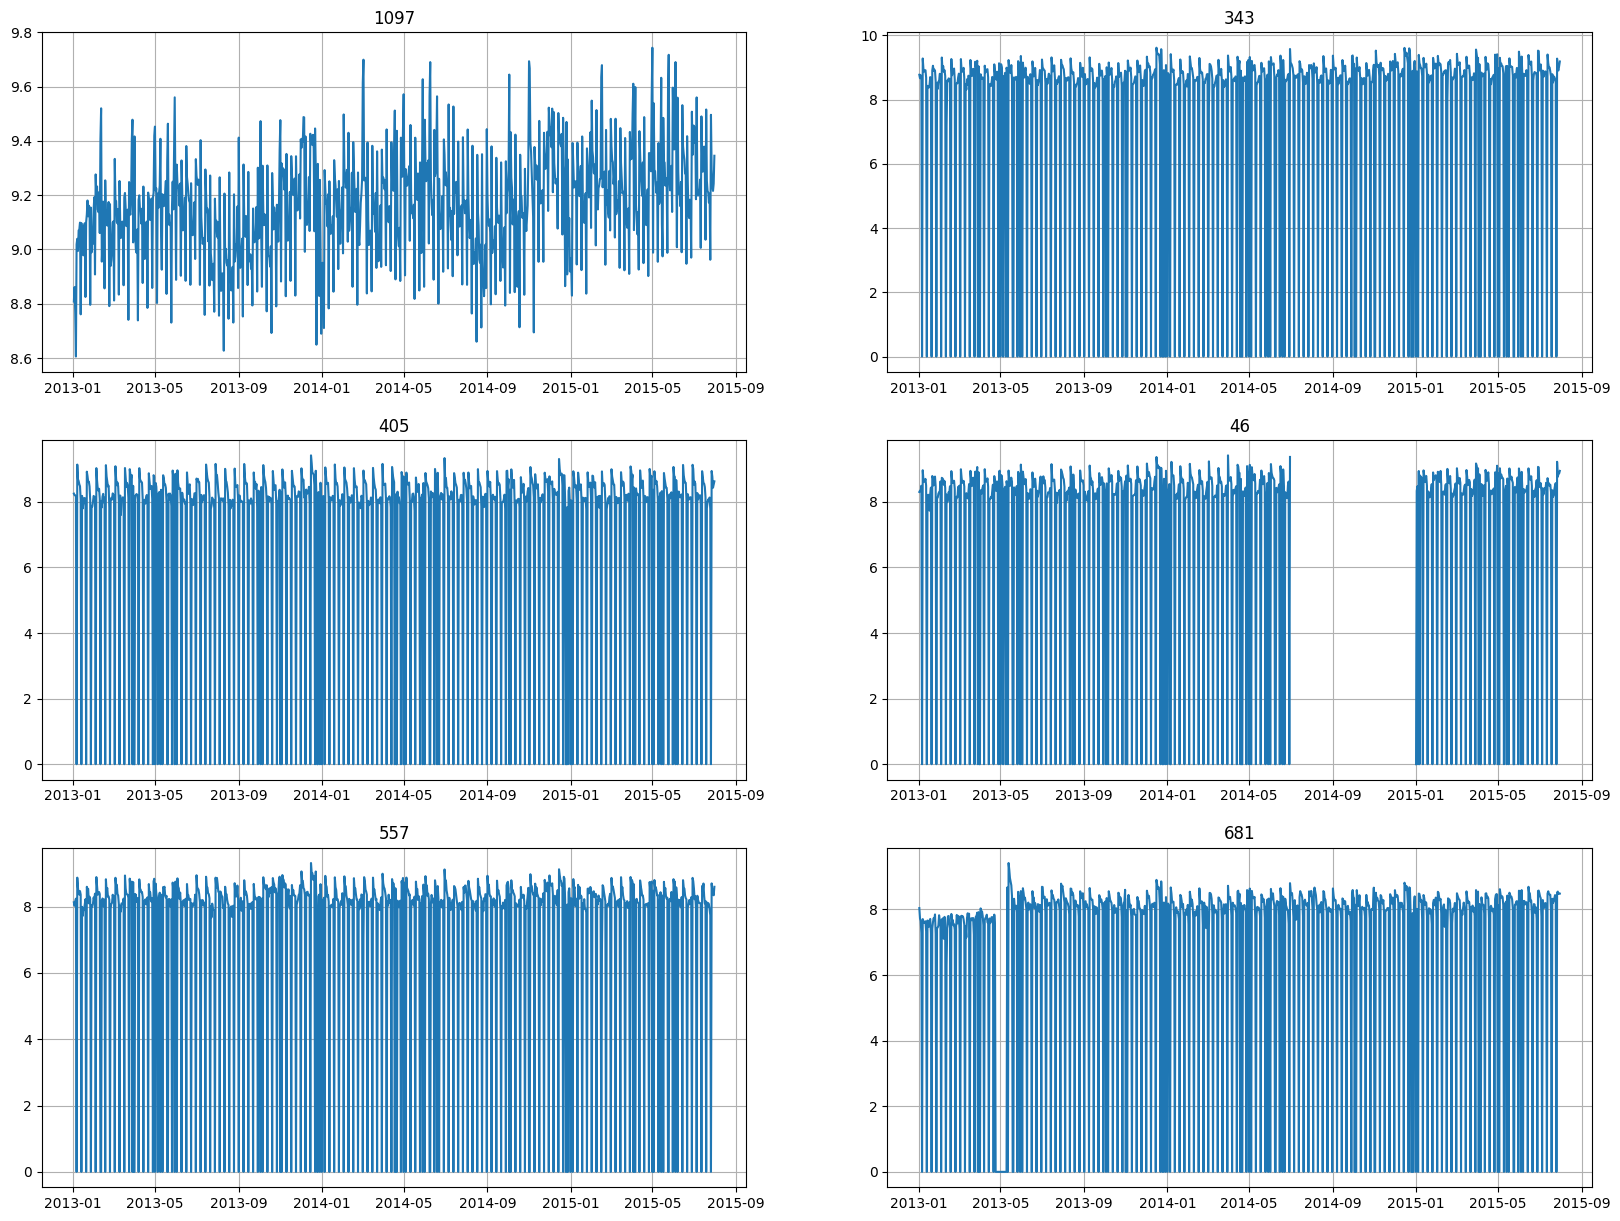

In [37]:
ts_df.plot(n_segments=6)
# TODO remove outliers! (like in 175 Store)

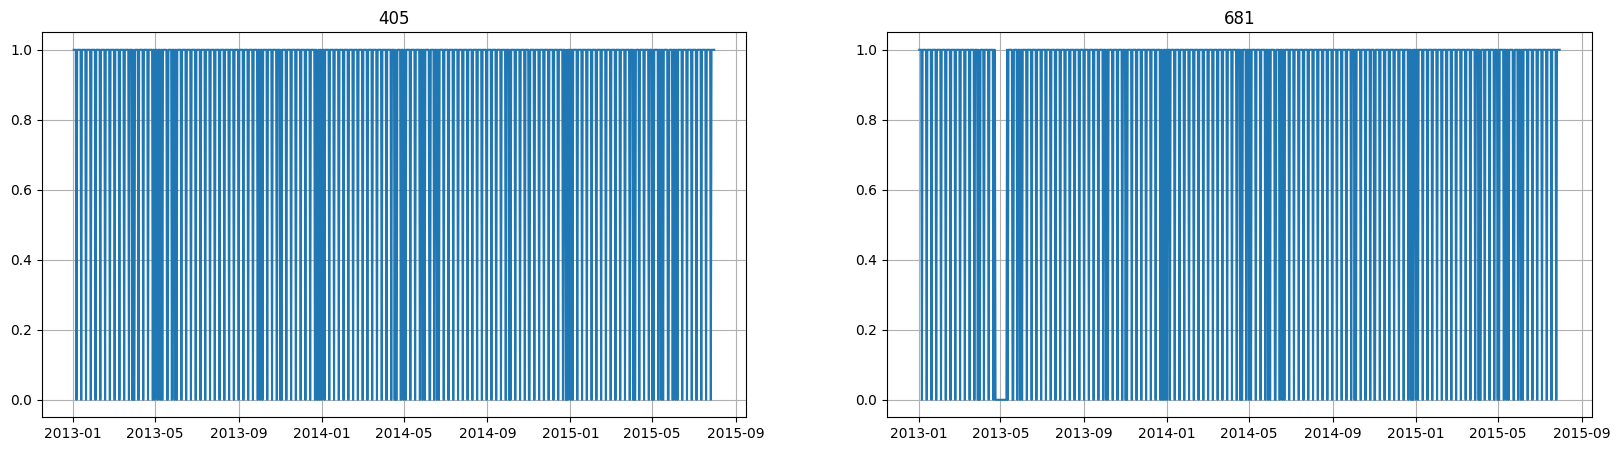

In [42]:
ts_df.plot(column="Open", n_segments=2)

Let's plot autocorrelation chart for 21 day 

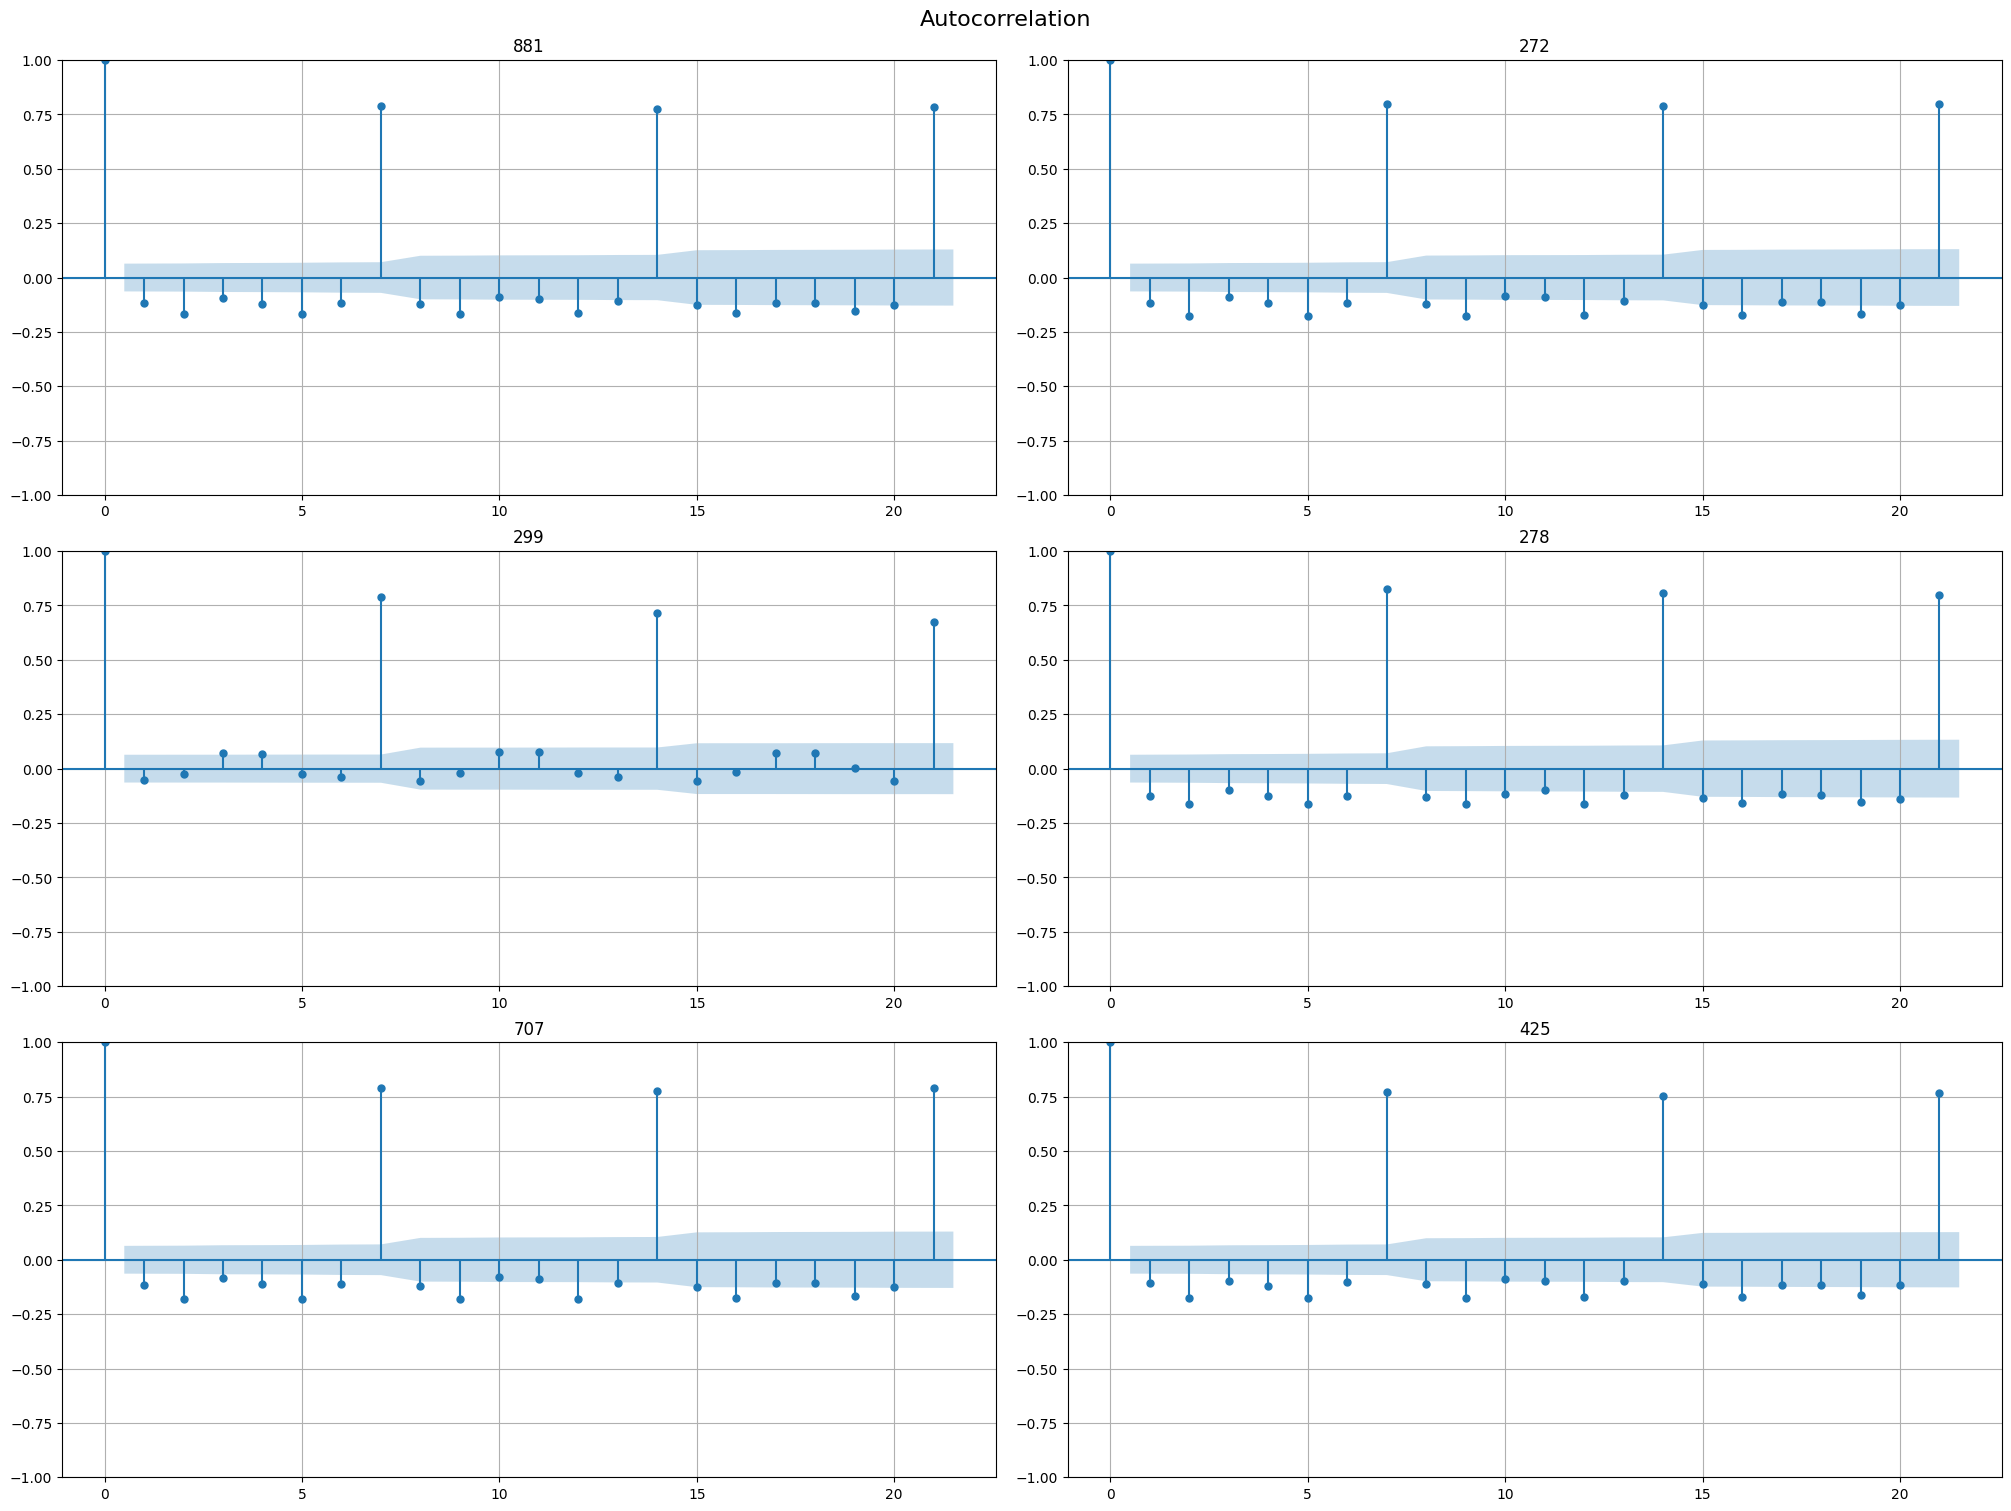

In [43]:
sample_acf_plot(ts_df, lags=21, n_segments=6)

We can see that there are great weekly autocorrelation. We will use 7 day lag as our baseline naive model

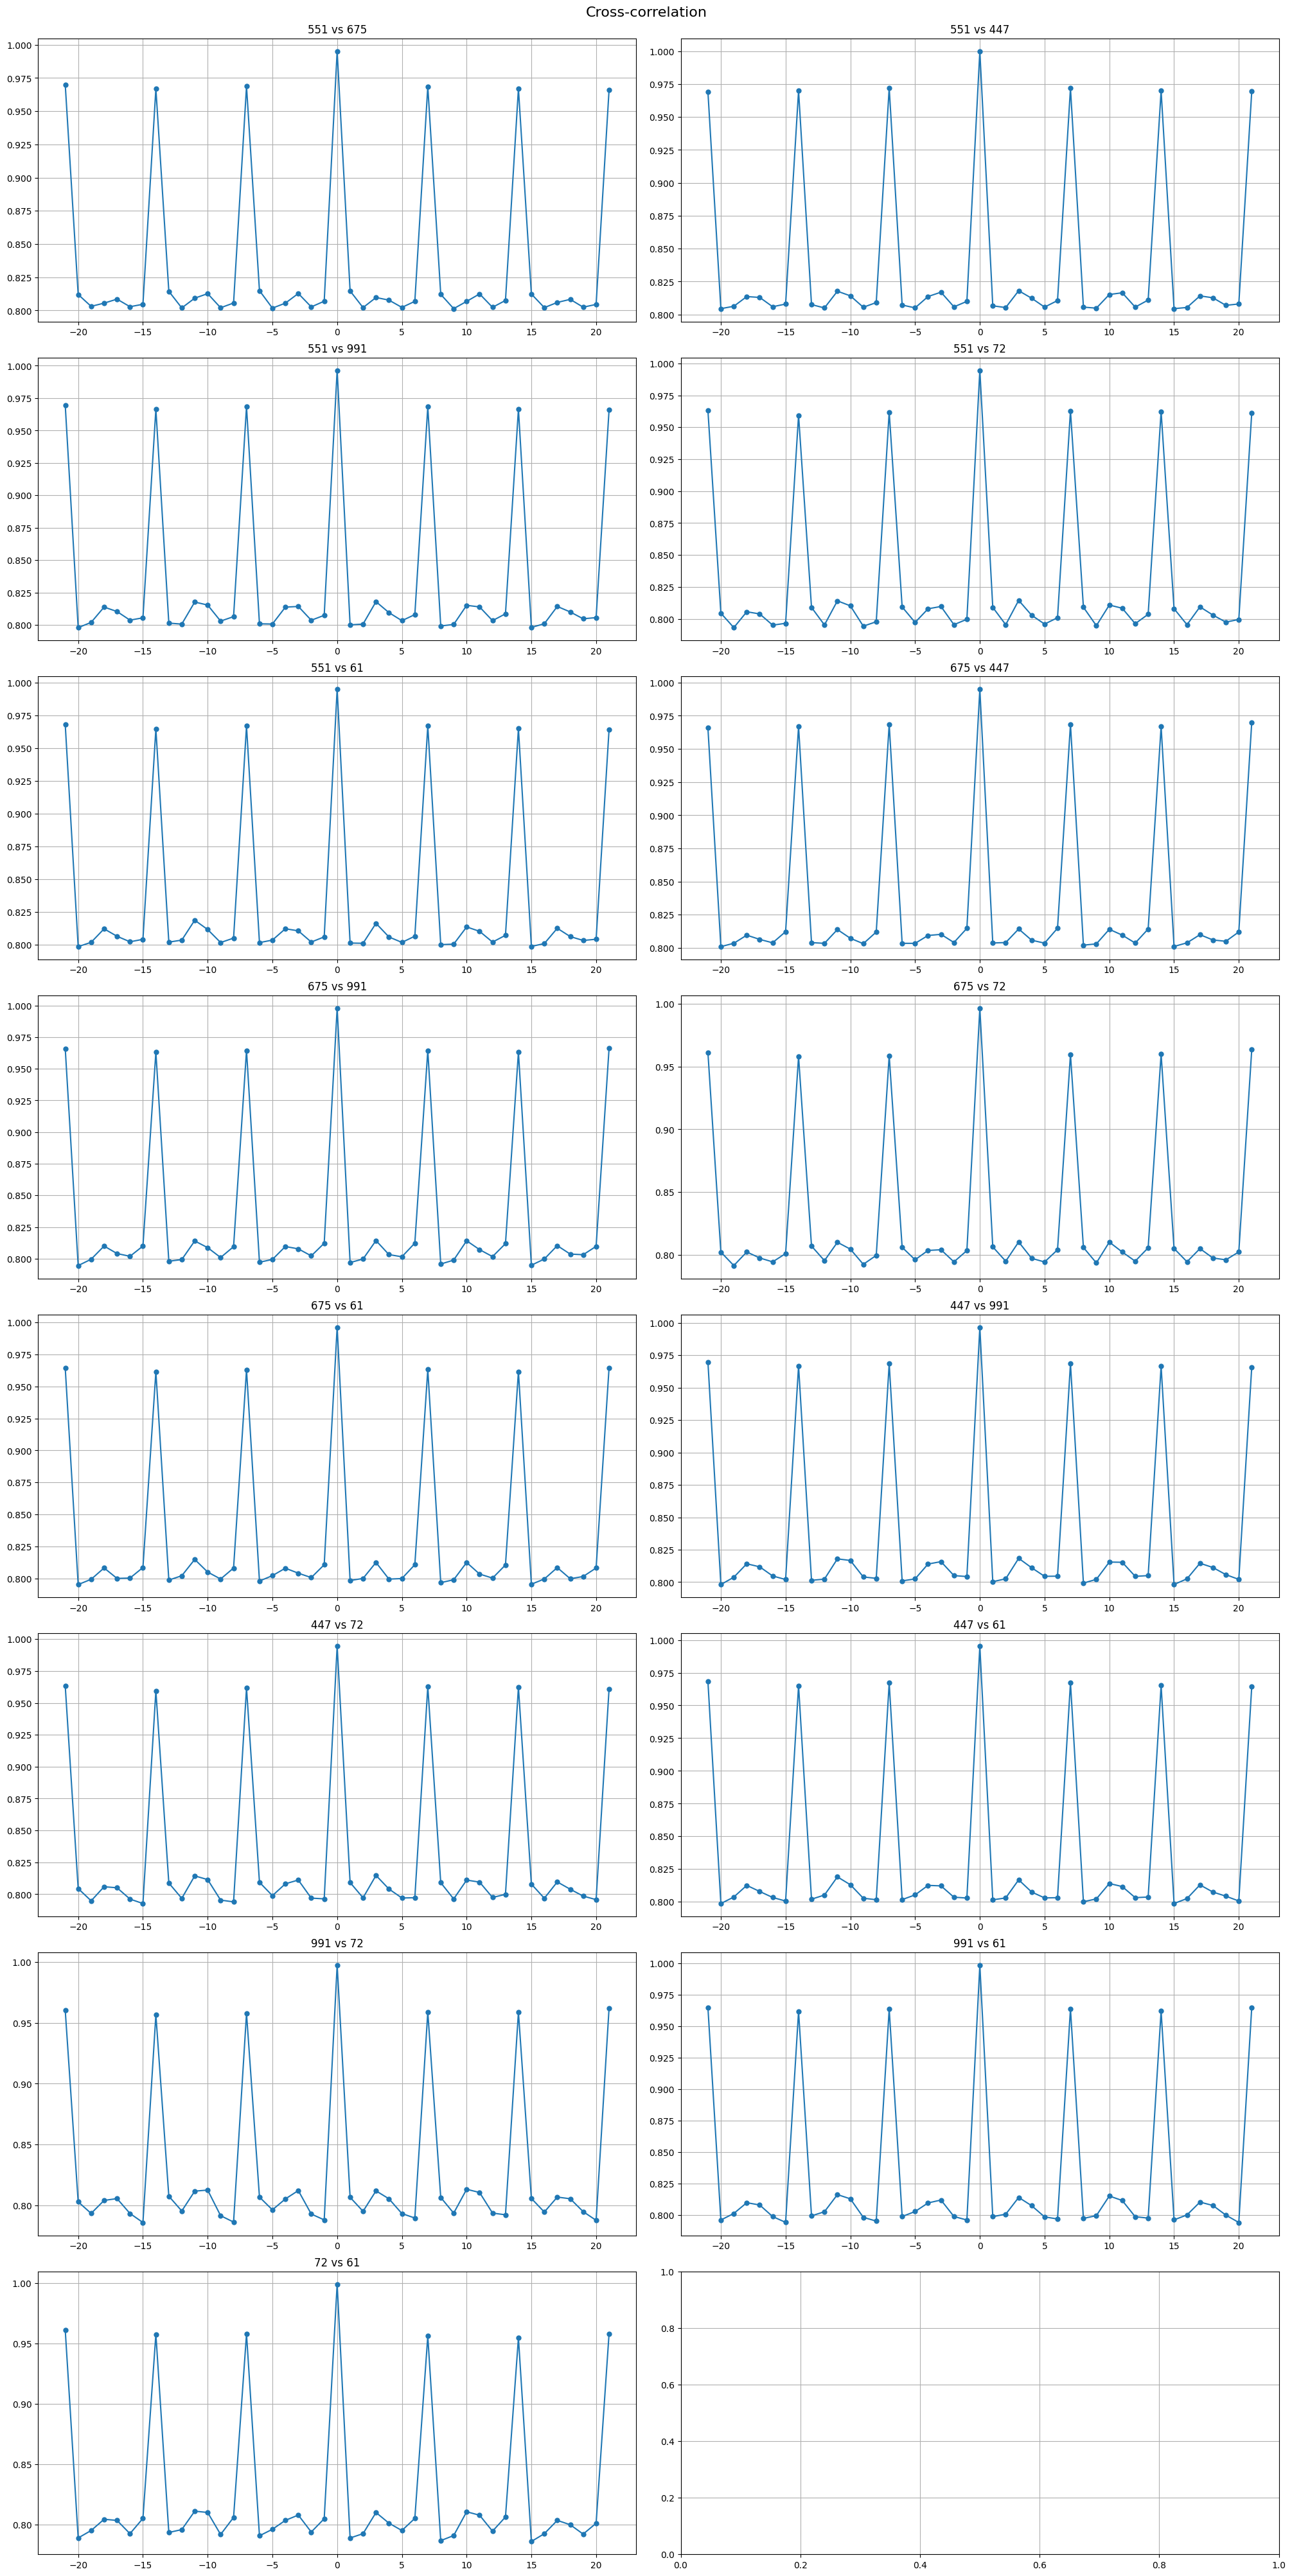

In [44]:
cross_corr_plot(ts_df, maxlags=21, n_segments=6)
# TODO so there are a lot of similar Stores. Almost identical - we can use it to impute lost data

There also seem like  a lot of similar Stores in terms of their cross-correlation. We can use similar Stores to fill NaNs in our data in next iterations.

# Step 3.1 Modeling

In [45]:
# anomaly_dict = get_anomalies_median(ts_df, window_size=21)
# TODO decide on anomaly filtering - come back when remove 0 Sales.
# anomaly_dict = get_anomalies_density(ts_df, window_size=14, distance_coef=1.5, n_neighbors=3,)
# problematic_segments = [it for it in anomaly_dict if len(anomaly_dict[it]) > 0]
# plot_anomalies(ts_df, anomaly_dict, segments=problematic_segments[:25])

Let's made train, eval split (Our test stored in exog variables)

In [85]:
ts_df = TSDataset(df=TSDataset.to_dataset(etna_train_df), freq="D",)# known_future="all", df_exog=TSDataset.to_dataset(etna_exog_df),)
train, validation = ts_df.train_test_split(test_size=HORIZON)
print("Train", train.describe().start_timestamp.max(), train.describe().end_timestamp.max())
print("Validation", validation.describe().start_timestamp.max(), validation.describe().end_timestamp.max())

Train 2013-01-02 00:00:00 2015-06-13 00:00:00
Validation 2015-06-14 00:00:00 2015-07-31 00:00:00


Lets define our baseline transformation pipeline

In [86]:
baseline_transforms = [
    TimeSeriesImputerTransform(in_column="target", strategy="seasonal", seasonality=14, window=21, default_value=0.0),
    TimeSeriesImputerTransform(in_column="target", strategy="forward_fill"),
    FilterFeaturesTransform(include=["target"])
]

In [88]:
from etna.models.naive import NaiveModel
model = NaiveModel(lag=14)
baseline_pipeline = Pipeline(model=model, transforms=baseline_transforms, horizon=HORIZON)
baseline_pipeline = baseline_pipeline.fit(train)

In [89]:
baseline_predictions = baseline_pipeline.forecast(prediction_interval=HORIZON, n_folds=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min finished


In [127]:
print("Predictions window: ", baseline_predictions.describe().start_timestamp.max(), baseline_predictions.describe().end_timestamp.max())


start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
1             2015-06-14    2015-07-31      48            0           856   
10            2015-06-14    2015-07-31      48            0           856   
100           2015-06-14    2015-07-31      48            0           856   
1000          2015-06-14    2015-07-31      48            0           856   
1003          2015-06-14    2015-07-31      48            0           856   
...                  ...           ...     ...          ...           ...   
991           2015-06-14    2015-07-31      48            0           856   
992           2015-06-14    2015-07-31      48            0           856   
994           2015-06-14    2015-07-31      48            0           856   
997           2015-06-14    2015-07-31      48            0           856   
998           2015-06-14    2015-07-31      48            0           856   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
1                 2               0                 0    D  
10                2               0                 0    D  
100               2               0                 0    D  
1000              2               0                 0    D  
1003              2               0                 0    D  
...             ...             ...               ...  ...  
991               2               0                 0    D  
992               2               0                 0    D  
994               2               0                 0    D  
997               2               0                 0    D  
998               2               0                 0    D  

[856 rows x 9 columns]

In [159]:
r_2_metric = R2(mode='per-segment')
baseline_metrics = pd.DataFrame.from_dict(r_2_metric(TSDataset(df=ts_df.loc[baseline_predictions.index], freq="D"), baseline_predictions), orient='index', columns=["Baseline R2"])


In [163]:
display(baseline_metrics[baseline_metrics["Baseline R2"] < 0].sort_values("Baseline R2"))
display(baseline_metrics["Baseline R2"].describe())

Baseline R2
274    -1.333146
733    -0.888963
183    -0.739172
70     -0.365643
530    -0.327824
769    -0.189789
909    -0.140397

count    856.000000
mean       0.437547
std        0.278207
min       -1.333146
25%        0.315914
50%        0.323821
75%        0.332208
max        0.999618
Name: Baseline R2, dtype: float64

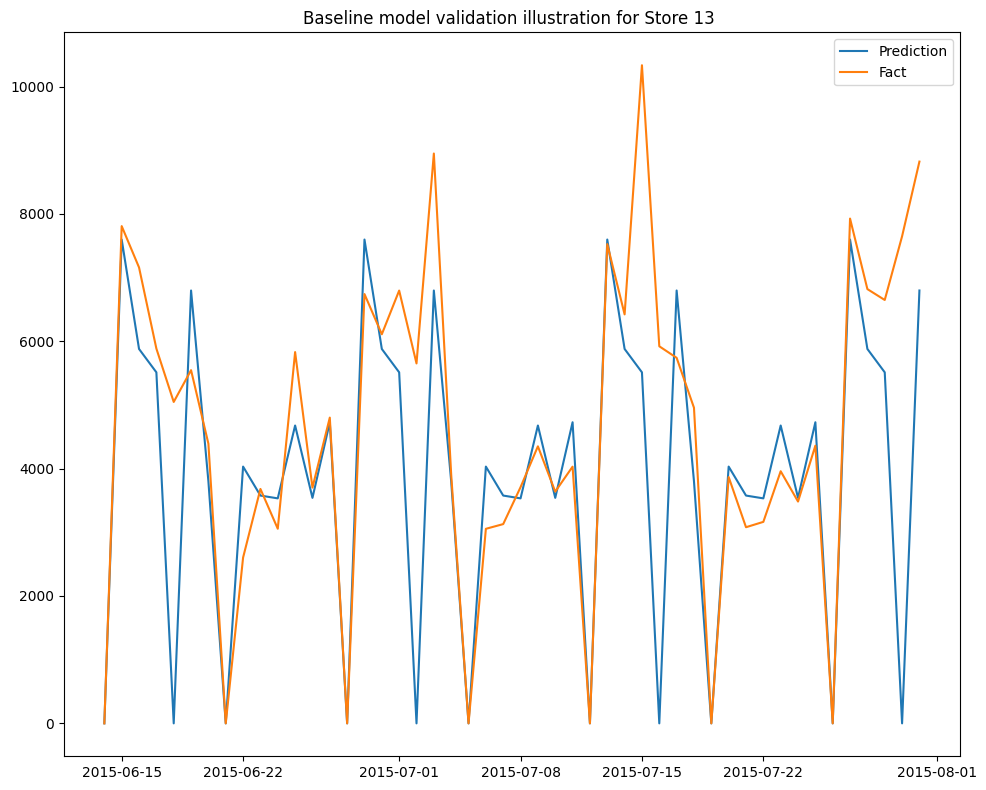

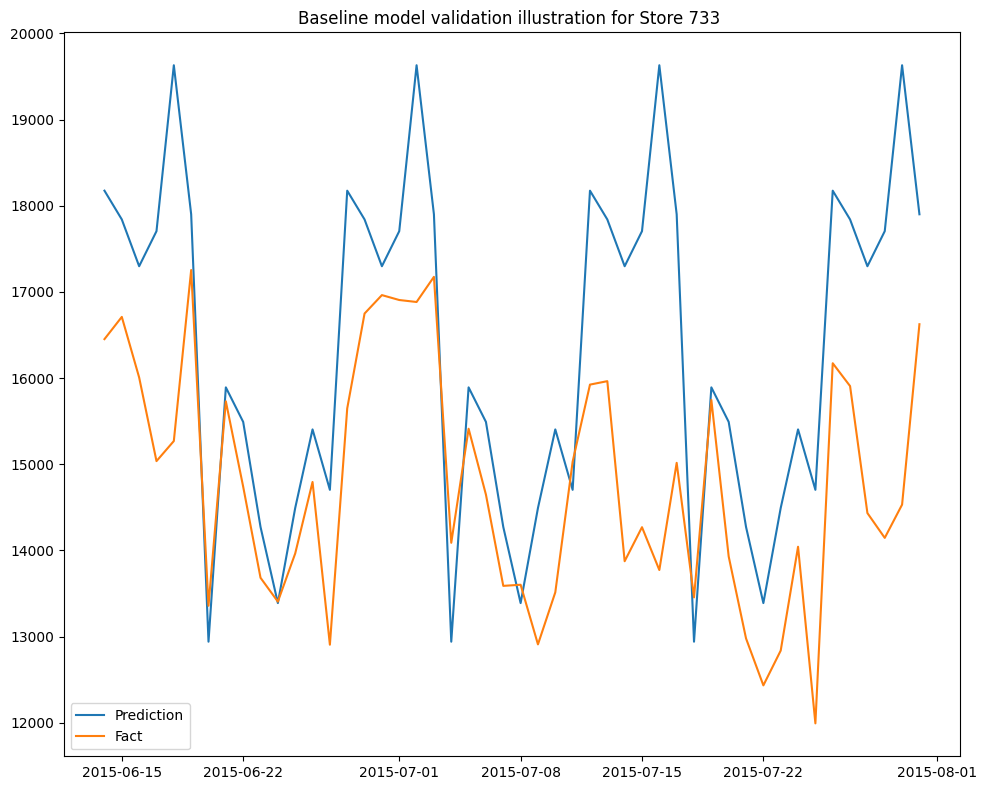

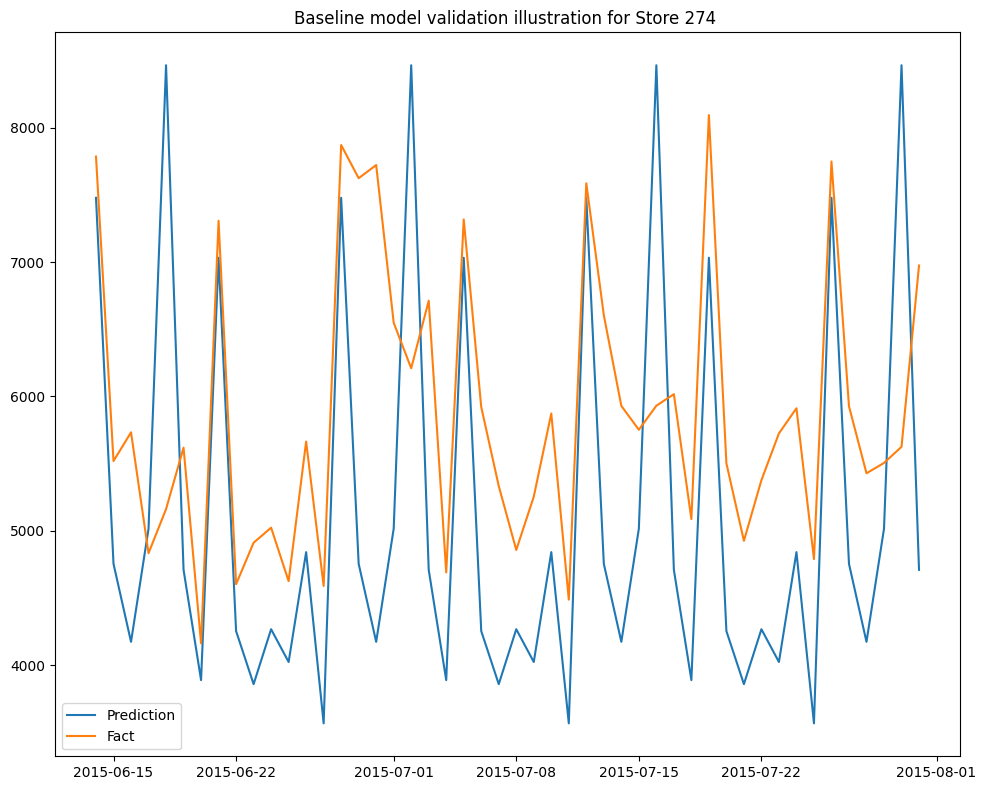

In [143]:
def plot_pred_vs_fact(preds, fact, store):
    plt.figure(figsize=(10,8))
    plt.plot(np.expm1(preds.loc[:, store]['target']), label="Prediction")
    plt.plot(np.expm1(fact.loc[preds.index, store]['target']), label="Fact")
    plt.title(f"Baseline model validation illustration for Store {store} ")
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_pred_vs_fact(baseline_predictions, ts_df, "13")
# plot_pred_vs_fact(baseline_predictions, ts_df,"42")
plot_pred_vs_fact(baseline_predictions, ts_df, "733")
plot_pred_vs_fact(baseline_predictions, ts_df, "274")


We can see that baseline model predicts pretty well for stable shops, while experience difficulties with shops with changed working hours (or smth else had happened - need to explore that)

### Step 3.1.1 Predict for train period

In [172]:
# predictions preparation
ts_df = TSDataset(df=TSDataset.to_dataset(etna_train_df), freq="D",)
baseline_test_pipeline = Pipeline(model=model, transforms=baseline_transforms, horizon=HORIZON)
baseline_test_pipeline = baseline_test_pipeline.fit(ts_df)
baseline_test_predictions = baseline_test_pipeline.forecast(prediction_interval=HORIZON, n_folds=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.5s finished


# Step 3.2 Catboost

In [147]:
catboost_ts_df = TSDataset(df=TSDataset.to_dataset(etna_train_df), freq="D", known_future="all", df_exog=TSDataset.to_dataset(etna_exog_df))
catboost_train, catboost_validation = catboost_ts_df.train_test_split(test_size=HORIZON)
print("Train", catboost_train.describe().start_timestamp.max(), catboost_train.describe().end_timestamp.max())
print("Validation", catboost_validation.describe().start_timestamp.max(), catboost_validation.describe().end_timestamp.max())

Train 2013-01-02 00:00:00 2015-06-13 00:00:00
Validation 2015-06-14 00:00:00 2015-07-31 00:00:00


In [148]:

catboost_transforms = [
    TimeSeriesImputerTransform(in_column="target", strategy="seasonal", seasonality=14, window=21, default_value=0.0),
    TimeSeriesImputerTransform(in_column="target", strategy="forward_fill"),
    TimeSeriesImputerTransform(in_column="Promo", strategy="constant", constant_value=0),
    TimeSeriesImputerTransform(in_column="Promo", strategy="forward_fill"),
    TimeSeriesImputerTransform(in_column="StateHoliday", strategy="constant", constant_value='0'),
    TimeSeriesImputerTransform(in_column="StateHoliday", strategy="forward_fill"),
    TimeSeriesImputerTransform(in_column="SchoolHoliday", strategy="constant", constant_value=0),
    TimeSeriesImputerTransform(in_column="SchoolHoliday", strategy="forward_fill"),
    LabelEncoderTransform(in_column="StateHoliday", out_column="StateHoliday"),
    LabelEncoderTransform(in_column="StateHoliday", out_column="StateHoliday"),
    LagTransform(
        in_column="target",
        lags=[1, 2, 3, 7, 14],
        out_column="target_lag",
    ),
    LagTransform(in_column="StateHoliday", lags=list(range(1, 3)), out_column="StateHoliday_lag"),
    MeanTransform(in_column="target", window=7, out_column="target_mean", seasonality=7),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        special_days_in_week=[6,7],
        out_column="date_flag",
    ),
    # FilterFeaturesTransform(include=["target", "segment", "timestamp", "Promo", "StateHoliday", "SchoolHoliday"])
]


In [149]:
catboost_model = CatBoostPerSegmentModel(iterations=100, learning_rate=5e-2)
catboost_pipeline = Pipeline(model=catboost_model, transforms=catboost_transforms, horizon=HORIZON)
# metrics_2, forecasts_2, _ = pipeline_2.backtest(train, metrics=[SMAPE(), R2(), RMSE()], aggregate_metrics=False, n_folds=2, n_jobs=1)
catboost_pipeline = catboost_pipeline.fit(catboost_train)


In [150]:
catboost_predictions = catboost_pipeline.forecast(prediction_interval=HORIZON, n_folds=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min finished


In [151]:
print("Predictions window: ", catboost_predictions.describe().start_timestamp.max(), catboost_predictions.describe().end_timestamp.max())

Predictions window:  2015-06-14 00:00:00 2015-07-31 00:00:00


In [164]:
r_2_metric = R2(mode='per-segment')
catboost_metrics = pd.DataFrame.from_dict(r_2_metric(TSDataset(df=ts_df.loc[catboost_predictions.index], freq="D"), catboost_predictions), orient='index', columns=["Catboost R2"])
display(catboost_metrics[catboost_metrics["Catboost R2"] < 0])
display(catboost_metrics["Catboost R2"].describe())

Catboost R2
769     -2.501200
274    -10.880095
863     -0.072918
122     -1.310233
1099    -0.225169
453     -2.316827
578     -2.315375
1097    -1.432124
676    -40.518863
867     -0.223919
732     -3.411270
1045    -1.300107
530    -13.137874
209     -0.211433
948     -9.965223
512     -1.819461
353    -15.508379
299     -2.812061
931     -3.134618
259     -8.304704

count    856.000000
mean       0.823423
std        1.755703
min      -40.518863
25%        0.991188
50%        0.994753
75%        0.996368
max        0.998721
Name: Catboost R2, dtype: float64

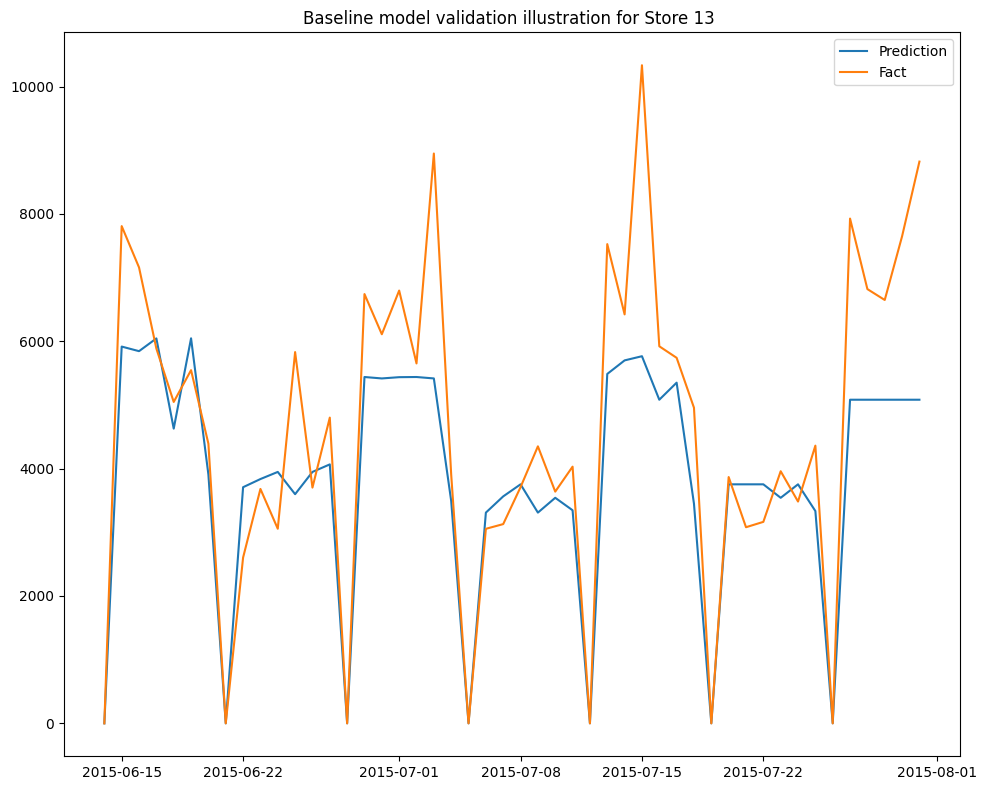

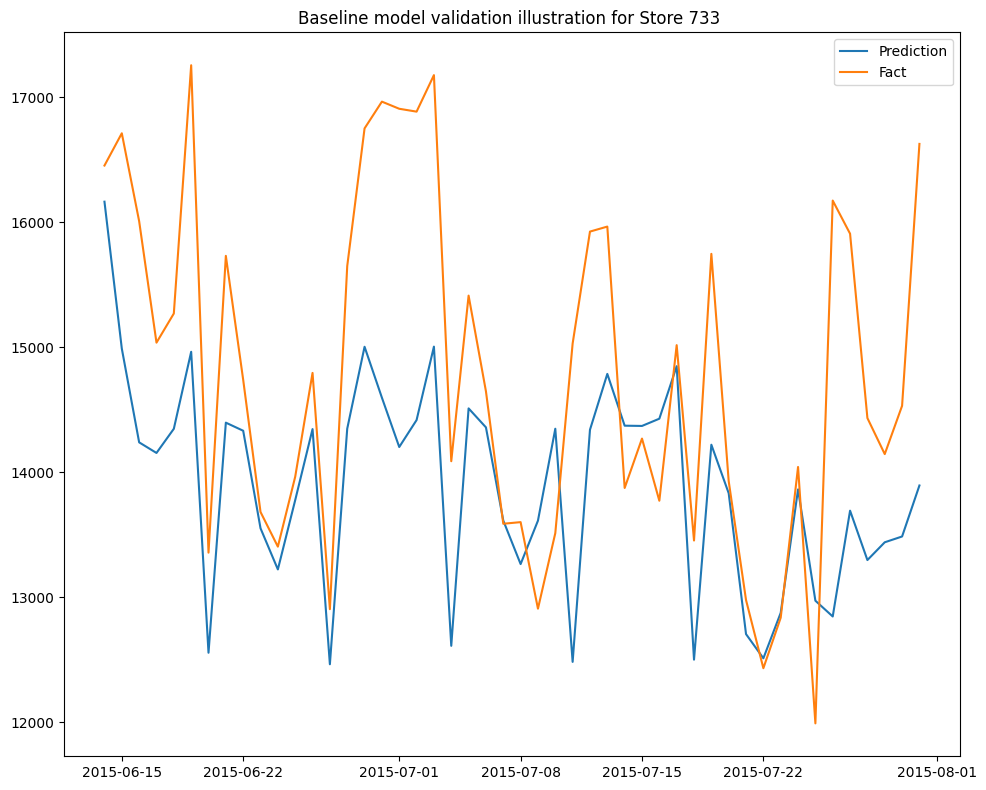

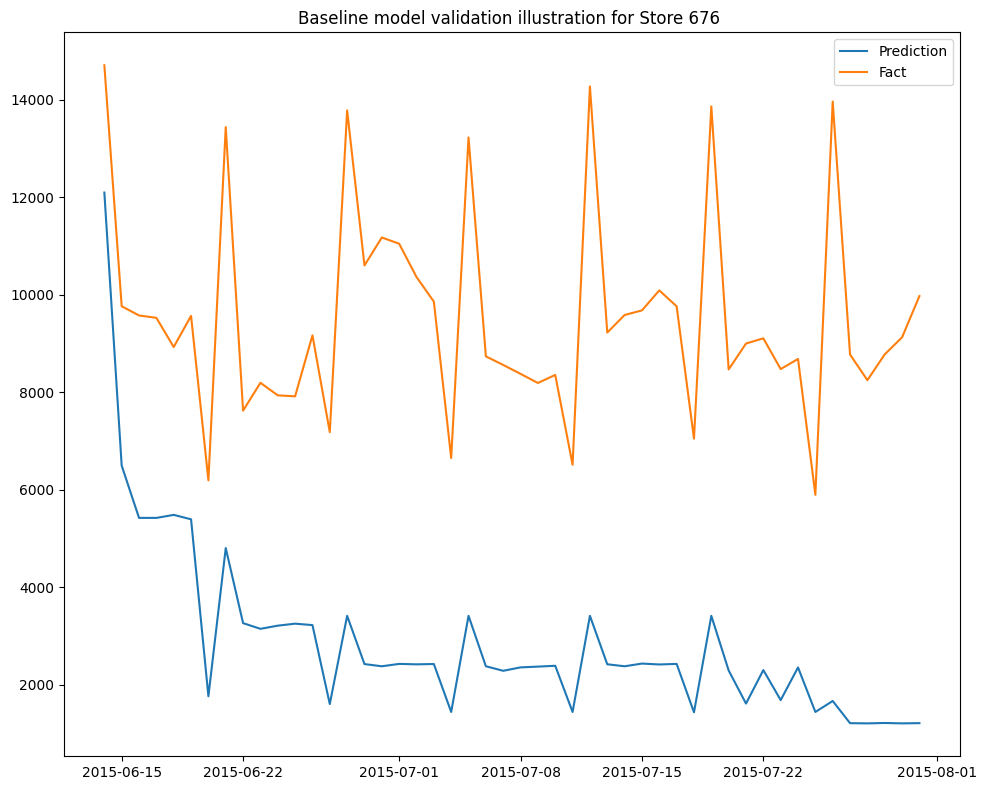

In [165]:
plot_pred_vs_fact(catboost_predictions, ts_df, "13")
# plot_pred_vs_fact(baseline_predictions, ts_df,"42")
plot_pred_vs_fact(catboost_predictions, ts_df, "733")
plot_pred_vs_fact(catboost_predictions, ts_df, "676")

Unfortunately, catboost did not fitted well on a given set of hyperparams. 
- If we have more time - I'd recommend to try to tune it or also try SARIMAX model.
- Anyway it has set of Stores where it's performing better than Baseline.
- Let's grab best from both models based on their validation performance and commit their greedy combination as prediction for test

In [195]:
metrics_comparison_df = catboost_metrics.T.append(baseline_metrics.T).T
catboost_segments_index = metrics_comparison_df[metrics_comparison_df['Catboost R2'] >= metrics_comparison_df['Baseline R2']].index
baseline_segments_index = metrics_comparison_df[metrics_comparison_df['Catboost R2'] < metrics_comparison_df['Baseline R2']].index
baseline_segments_index, catboost_segments_index

(Index(['538', '278', '802', '212', '769', '180', '274', '301', '863', '230',
        ...
        '662', '741', '259', '1024', '484', '304', '432', '901', '15', '262'],
       dtype='object', length=168),
 Index(['336', '651', '955', '204', '188', '33', '928', '19', '238', '394',
        ...
        '470', '739', '371', '884', '727', '132', '69', '144', '280', '169'],
       dtype='object', length=688))

### Step 3.2.1 Predictions for test

In [171]:
# # predictions preparation
# # ts_df = TSDataset(df=TSDataset.to_dataset(etna_train_df), freq="D",)
catboost_test_pipeline = Pipeline(model=catboost_model, transforms=catboost_transforms, horizon=HORIZON)
catboost_test_pipeline = catboost_test_pipeline.fit(catboost_ts_df)
catboost_test_predictions = catboost_test_pipeline.forecast(prediction_interval=HORIZON, n_folds=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min finished


## Step 4. Predictions combination

In [196]:
def transform_ts_preds_in_pandas(ts_preds, segments):
    pandas_df = TSDataset(df=ts_preds.loc[:, segments], freq="D").to_pandas(True)
    pandas_df['Sales'] = pandas_df.target.apply(np.expm1)
    pandas_df.rename( inplace=True, columns={'segment': "Store", 'timestamp':"Date"})
    return pandas_df[['Date', 'Store', "Sales"]]

In [197]:
pandas_baseline_test_predictions_df = transform_ts_preds_in_pandas(baseline_test_predictions, baseline_segments_index)
pandas_catboost_test_predictions_df = transform_ts_preds_in_pandas(catboost_test_predictions, catboost_segments_index)

full_test_predictions_df = pandas_baseline_test_predictions_df.append(pandas_catboost_test_predictions_df, ignore_index=True)
full_test_predictions_df.Store = full_test_predictions_df.Store.astype(np.int64)
full_test_predictions_df

Date  Store        Sales
0     2015-08-01    538  2367.000000
1     2015-08-02    538     0.000000
2     2015-08-03    538  4274.000000
3     2015-08-04    538  3346.000000
4     2015-08-05    538  3083.000000
...          ...    ...          ...
41083 2015-09-13    169     0.080611
41084 2015-09-14    169  5946.653960
41085 2015-09-15    169  5897.646638
41086 2015-09-16    169  5884.587953
41087 2015-09-17    169  5884.587953

[41088 rows x 3 columns]

In [200]:
results_df = test_df.merge(full_test_predictions_df, on=["Date", "Store"], how='left')
print(" Sanity checks: ")
print("Not-covered Stores: ")
display(results_df[results_df.Sales.isna()].Store.value_counts())
closed_stores_index = results_df[(results_df.Open == 0) & (results_df.Sales != 0)].index
for _ind in closed_stores_index:
    results_df.at[_ind, "Sales"] = 0.0
print(f"Sales for closed Stores fixed days : {len(closed_stores_index)}")

 Sanity checks: 
Not-covered Stores: 


Series([], Name: Store, dtype: int64)

Sales for closed Stores fixed days : 4983


In [202]:
results_df.to_csv("./data/output/test_prediction.csv", index=False, mode='w')

# Summary and what can be improved in long-term case
I enjoed to work with this datase. It was pretty challenging since i had to learn how to use new tool - etna lib. 

## Some data insights:
- `Open` feature should be used as rule of thumb for predictions postprocessing (When store is closed - no sales should appear)
- `StateHoliday` - majority of shops doesn't work on such holidays, but 156 of them does.
- In our data prevail inter-week and monthly seasonality -- pretty common for retail stores
- `Promo` activities affect both # of customers and amount of `Sales` --> It should be an important seasonality factor in future models
- `SchoolHoliday` effect depends on `DayOfWeek` --> we can create quadratic feature for that
- Data quality jobs should be incorporated to clean data before updating a pipeline.

## Feasible Next Steps:
- Consult with Business about business metric and how they plan utilize our forecast --> It should define priority for the following steps
- Build pipeline without Zeroes(0) in target 
- Filter Zero Sales --> check outliers (Sorry, have no time for that)
- Calculate SHAPE values for boosting model --> add more interpretability for us and the business
- Perform Hyperparameter tuning with `Optuna`-like tools
- Try different model families like SARIMAX, Prophet, DeepAR
- Try not to predict Sales per shop but somehow group them \ reformulate the whole task.
- Look on residuals (Sorry, forgot about them)
- continue on feature engineering:
    - `Promo2` + `Promo2Since` + `PromoInterval` logic
    - Quadratic features like `SchoolHoliday` x `DayOfWeek`
    - Explore on Competitors distance effect on the sales
## Challenges with data:
- In some `Stores` there a huge gap in data for second part of 2014 year for all features
    - We can to build generic model that will be trained on all stores dynamic
    - Use some definition of `Nearest neighbor shop` (i.e. based on cross-correlation or Dynamic time warping) and replace missing data with mix of 3\5 nearest neighbors (size of shops + their promo interval matter)
- Zero `Sales` for `Open` days -- Very likely error in labeling\data processing process.